<a href="https://colab.research.google.com/github/oksuzian/Mu2eANL/blob/master/Wideband/Aging_CRV127.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Init and get a ticket

In [1]:
!pip install -q hist
!pip install -q mplhep==0.2.9 # Latest version requires new version of matplot lib
!pip install -q uproot
!pip install lmfit

import hist

import mplhep as hep
hep.style.set_style('ATLAS')  # or ATLAS/LHCb2

     |████████████████████████████████| 1.4 MB 8.1 MB/s 
     |████████████████████████████████| 5.4 MB 3.8 MB/s 
     |████████████████████████████████| 302 kB 6.3 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 292 kB 5.1 MB/s 
     |████████████████████████████████| 98 kB 7.4 MB/s 
  Created wheel for lmfit: filename=lmfit-1.0.3-py3-none-any.whl size=84413 sha256=ac7608611de4d82f666cb9b27c99887f4b68248480cbfb60384b4ed29d389090
  Stored in directory: /root/.cache/pip/wheels/b9/7a/d1/236aa0f8196b264fda481a112f7cfb1bfde7bfb20235f8e331
Successfully built lmfit


In [81]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import datetime as dt
import os
import subprocess
import numpy as np
import matplotlib.dates as mdates
import seaborn as sns
import uproot
from scipy import stats
import re
import glob
import sys
import lmfit
from lmfit.models import LinearModel
pd.set_option('display.max_columns', None)
#pd.set_option('display.max_rows', None)
#pd.set_option('display.max_rows', 100)
plt.rcParams.update({'figure.max_open_warning': 0})
BAD_RUNS=[42, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 64, 66, 67, 68, 69, 80, 83, 87, 88, 89, 91, 96, 101, 105, 110, 115, 1027]

In [3]:
!apt-get -qq install krb5-user > /dev/null
!wget https://authentication.fnal.gov/krb5conf/Linux/krb5.conf
import os
os.environ['KRB5_CONFIG'] = 'krb5.conf'
!kinit oksuzian@FNAL.GOV

--2022-09-08 04:00:14--  https://authentication.fnal.gov/krb5conf/Linux/krb5.conf
Resolving authentication.fnal.gov (authentication.fnal.gov)... 131.225.105.240, 2620:6a:0:105::105:240
Connecting to authentication.fnal.gov (authentication.fnal.gov)|131.225.105.240|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 17486 (17K) [text/plain]
Saving to: ‘krb5.conf’

krb5.conf           100%[===================>]  17.08K  --.-KB/s    in 0.01s   

2022-09-08 04:00:15 (1.42 MB/s) - ‘krb5.conf’ saved [17486/17486]

Password for oksuzian@FNAL.GOV: 


#Get tarballs with txt and pdf files

In [4]:
#!scp  -r -o StrictHostKeyChecking=no -o GSSAPIAuthentication=yes -o GSSAPIDelegateCredentials=yes oksuzian@mu2egpvm03.fnal.gov:/pnfs/mu2e/tape/phy-etc/bck/mu2e/CRV_wideband_cosmics/crvaging-001 .
!scp  -r -o StrictHostKeyChecking=no -o GSSAPIAuthentication=yes -o GSSAPIDelegateCredentials=yes oksuzian@mu2egpvm03.fnal.gov:/mu2e/data/users/oksuzian/crvaging-001/rec.mu2e.CRV_wideband_cosmics.crvaging-001.*.root .
#!cp crvaging-001/tgz/*/*/bck.mu2e.CRV_wideband_cosmics.crvaging-001.*.tgz .
#!for f in bck.mu2e.CRV_wideband_cosmics.crvaging-001.*.tgz; do tar xf "$f"; done

In [28]:
key_list = uproot.open('rec.mu2e.CRV_wideband_cosmics.crvaging-001.000051_000.root').keys()
list(filter(('spills;1').__ne__, key_list))

key_list[:] = [x for x in key_list if "spills" not in x]
print(key_list)

['runSummary;1']


In [99]:
df = pd.DataFrame()
listing = glob.glob('rec.*.root')
for root_file in listing:
  print(root_file)
  run = int(re.split('\.|_', root_file)[6])
  subrun = int(re.split('\.|_', root_file)[7])
  if run in BAD_RUNS:
    continue

  for key in uproot.open(root_file).keys():
    if 'spill' in key:
      continue
    tree = uproot.open(root_file+":"+key)
    df_ = tree.arrays(library="pd")
    df_.columns = df_.columns.str.replace(r'\[', '_')
    df_.columns = df_.columns.str.replace(r'\]', '')

    df_['run'] = int(run)
    df_['subrun'] = int(subrun)
    df = df.append(df_)

rec.mu2e.CRV_wideband_cosmics.crvaging-001.001037_001.root


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: FutureWarning: The default value of regex will change from True to False in a future version.
  from ipykernel import kernelapp as app
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: FutureWarning: The default value of regex will change from True to False in a future version.
  app.launch_new_instance()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=

rec.mu2e.CRV_wideband_cosmics.crvaging-001.000049_000.root
rec.mu2e.CRV_wideband_cosmics.crvaging-001.000053_002.root
rec.mu2e.CRV_wideband_cosmics.crvaging-001.000067_000.root
rec.mu2e.CRV_wideband_cosmics.crvaging-001.000094_003.root
rec.mu2e.CRV_wideband_cosmics.crvaging-001.000087_009.root
rec.mu2e.CRV_wideband_cosmics.crvaging-001.000091_011.root
rec.mu2e.CRV_wideband_cosmics.crvaging-001.000054_002.root
rec.mu2e.CRV_wideband_cosmics.crvaging-001.000087_005.root
rec.mu2e.CRV_wideband_cosmics.crvaging-001.000083_004.root
rec.mu2e.CRV_wideband_cosmics.crvaging-001.000091_009.root
rec.mu2e.CRV_wideband_cosmics.crvaging-001.000083_001.root
rec.mu2e.CRV_wideband_cosmics.crvaging-001.001033_001.root
rec.mu2e.CRV_wideband_cosmics.crvaging-001.000091_012.root
rec.mu2e.CRV_wideband_cosmics.crvaging-001.000091_014.root
rec.mu2e.CRV_wideband_cosmics.crvaging-001.000105_004.root
rec.mu2e.CRV_wideband_cosmics.crvaging-001.000087_004.root
rec.mu2e.CRV_wideband_cosmics.crvaging-001.000094_004.ro

<Figure size 630x426.24 with 0 Axes>

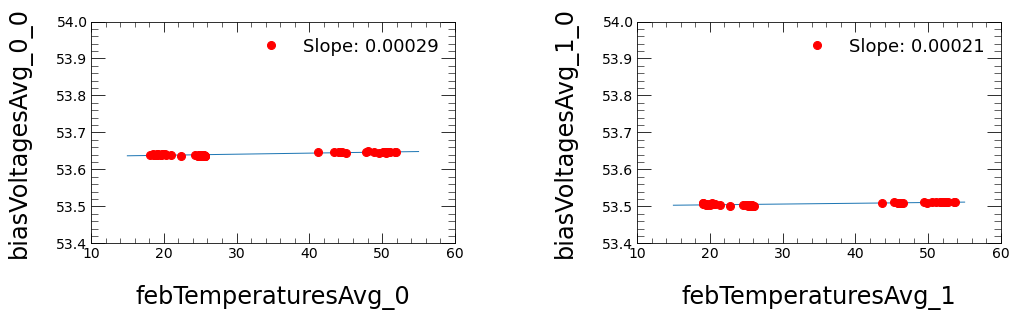

<Figure size 630x426.24 with 0 Axes>

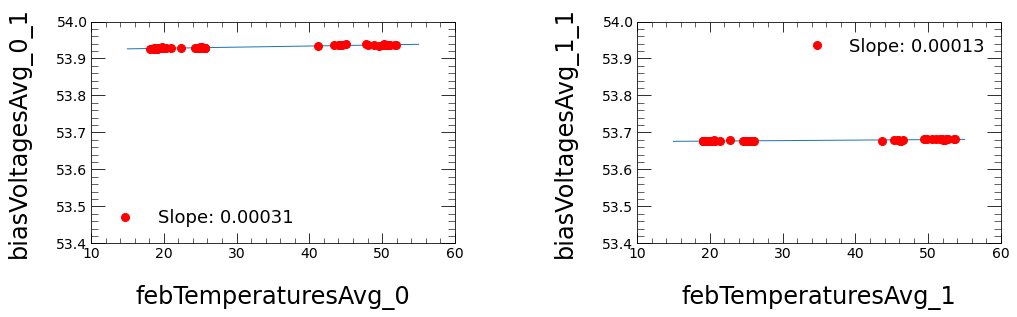

<Figure size 630x426.24 with 0 Axes>

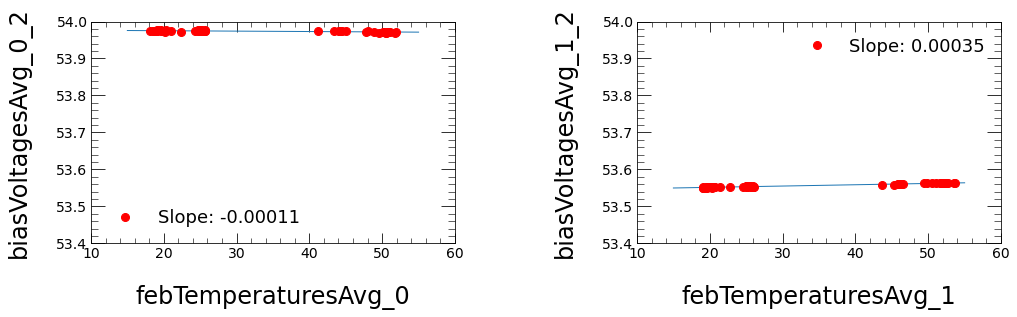

<Figure size 630x426.24 with 0 Axes>

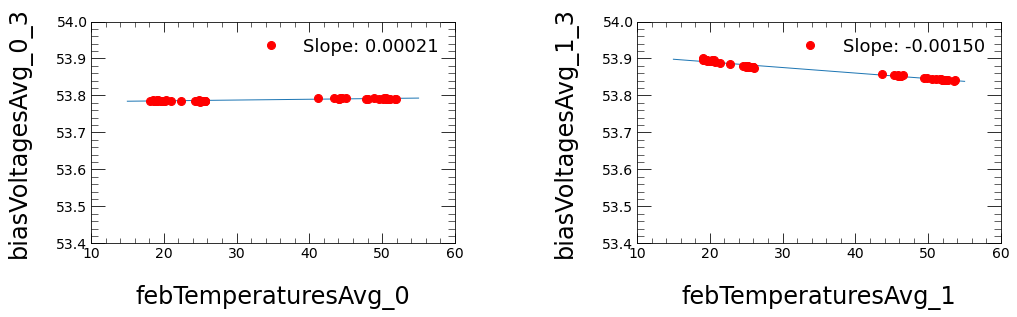

<Figure size 630x426.24 with 0 Axes>

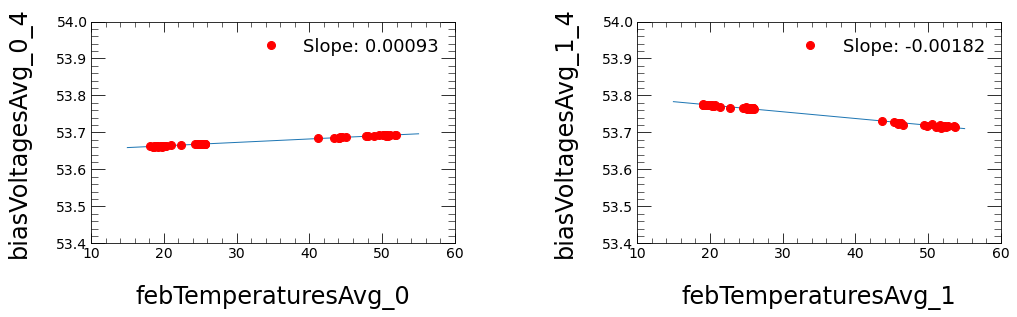

<Figure size 630x426.24 with 0 Axes>

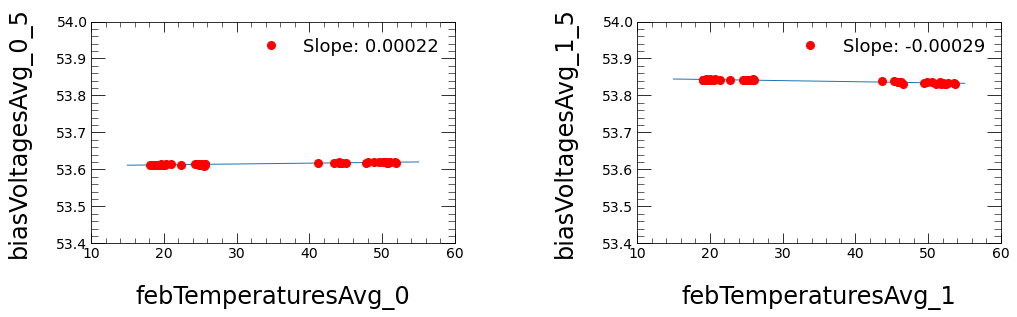

<Figure size 630x426.24 with 0 Axes>

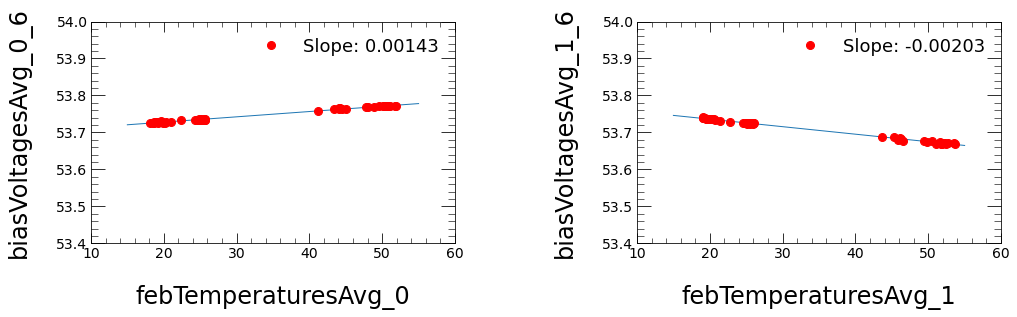

<Figure size 630x426.24 with 0 Axes>

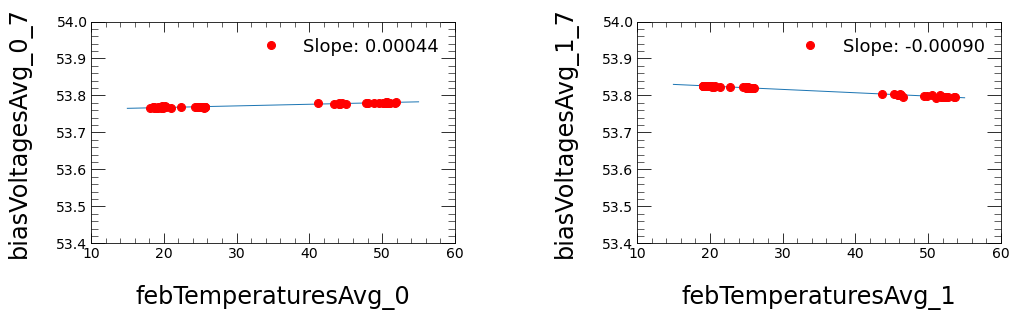

In [61]:
for i in range(0,8):

  plt.figure()
  fig, ax1 = plt.subplots(nrows=1, ncols=2, figsize=(16, 4))
  plt.subplots_adjust(wspace=0.5)


  for feb in range(0, 2):
    x=df['febTemperaturesAvg_%d'%(feb)]
    y=df['biasVoltagesAvg_%d_%d'%(feb, i)]

    linmodel = np.poly1d(np.polyfit(x, y, 1))
    xline = np.linspace(15, 55, 100)
    ax1[feb].plot(xline, linmodel(xline))
    ax1[feb].plot(x,y,'ro', label='Slope: %.5f'%linmodel.coeffs[0])

    ax1[feb].set_xlabel('febTemperaturesAvg_%d'%(feb))
    ax1[feb].set_ylabel('biasVoltagesAvg_%d_%d'%(feb, i))
    ax1[feb].set_xlim(10,60)
    ax1[feb].set_ylim(53.4,54)
    ax1[feb].legend()

In [76]:
df = df.sort_values('timestamp')

#df = pd.merge(df_data, df_calib,  how='left', on=['feb','chan', 'run', 'subrun'])
#df = pd.merge(df_run_date, df, on="run")

#Convert columns to proper data types
df['date'] = pd.to_datetime(df['timestamp']).dt.date
#df['run'] = df['run'].astype(int)
#df['subrun'] = df['subrun'].astype(int)

#Ramove bad runs
#BAD_RUNS=[42, 44, 45, 46, 47, 48, 49, 50, 52, 53, 54, 55, 56, 57, 59, 60, 61, 62, 64, 67, 68, 69, 80, 83, 87, 88, 89, 91, 96, 101, 110, 115]
#df = df[~df.run.isin(BAD_RUNS)]

#df = df.query('PEcorr>0')
df['hours']=df['timestamp']/3600
df['days']=df['hours']/24

pd.options.mode.chained_assignment = None
df['years']=(df['days']-df.query('days>=0')['days'].min())/365 #Convert to years

In [63]:
'''
!scp oksuzian@mu2egpvm03.fnal.gov:/mu2e/data/users/oksuzian/WidebandTempSensor_20220624.csv .
df_temp = pd.read_csv("WidebandTempSensor_20220624.csv", sep=",", skiprows=2, names=["idx","date","temp","rh","dew"])
df_temp['date'] = pd.to_datetime(df_temp['date']).dt.date
df_temp['days'] = df_temp['date'].map(dt.datetime.toordinal)
df_temp['years_temp'] = (df_temp['days']-df['days'].min())/365 #Convert to years
df_temp['temp'] = (df_temp['temp'] - 32)*5.0/9.0

df_temp_dailyave = df_temp.groupby('days').mean().reset_index()
df = pd.merge(df_temp_dailyave, df, on="days")
'''

'\n!scp oksuzian@mu2egpvm03.fnal.gov:/mu2e/data/users/oksuzian/WidebandTempSensor_20220624.csv .\ndf_temp = pd.read_csv("WidebandTempSensor_20220624.csv", sep=",", skiprows=2, names=["idx","date","temp","rh","dew"])\ndf_temp[\'date\'] = pd.to_datetime(df_temp[\'date\']).dt.date\ndf_temp[\'days\'] = df_temp[\'date\'].map(dt.datetime.toordinal)\ndf_temp[\'years_temp\'] = (df_temp[\'days\']-df[\'days\'].min())/365 #Convert to years\ndf_temp[\'temp\'] = (df_temp[\'temp\'] - 32)*5.0/9.0\n\ndf_temp_dailyave = df_temp.groupby(\'days\').mean().reset_index()\ndf = pd.merge(df_temp_dailyave, df, on="days")\n'

<Figure size 630x426.24 with 0 Axes>

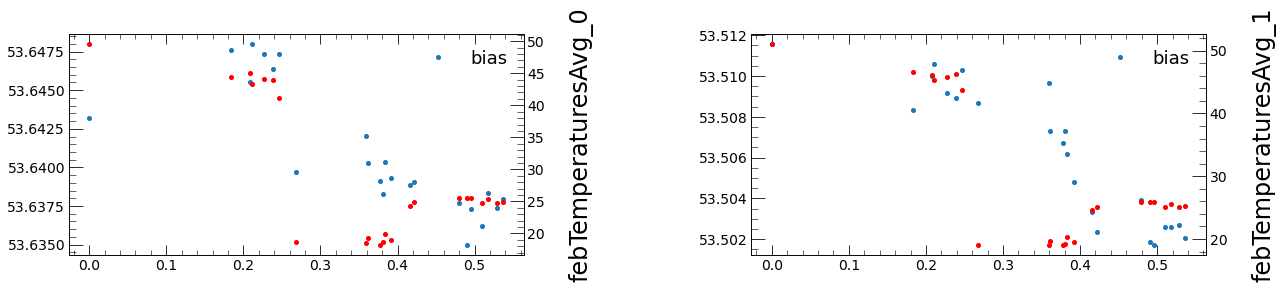

<Figure size 630x426.24 with 0 Axes>

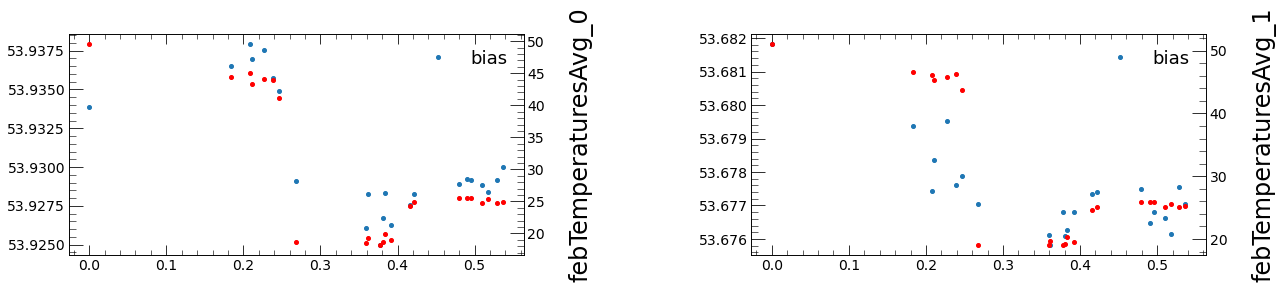

<Figure size 630x426.24 with 0 Axes>

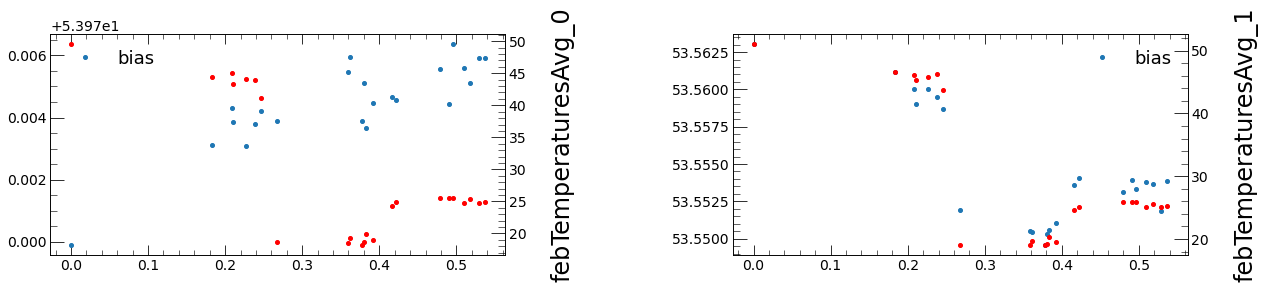

<Figure size 630x426.24 with 0 Axes>

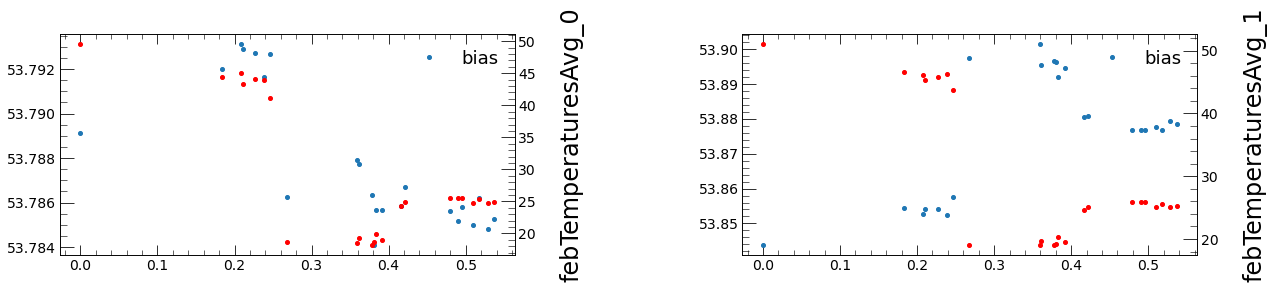

<Figure size 630x426.24 with 0 Axes>

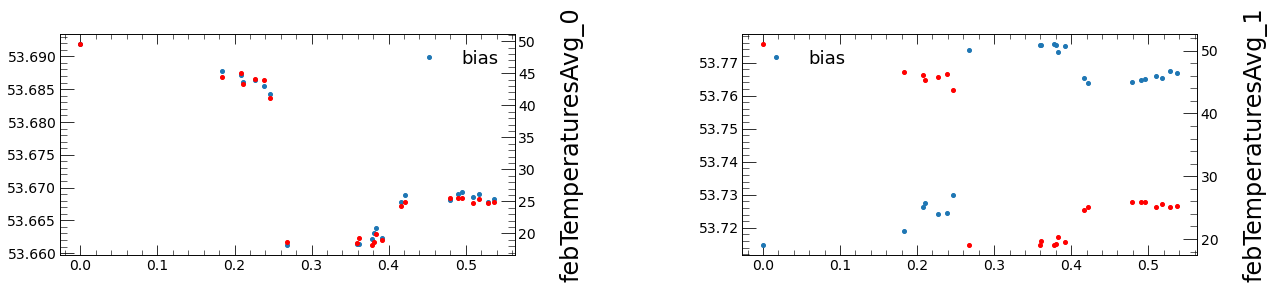

<Figure size 630x426.24 with 0 Axes>

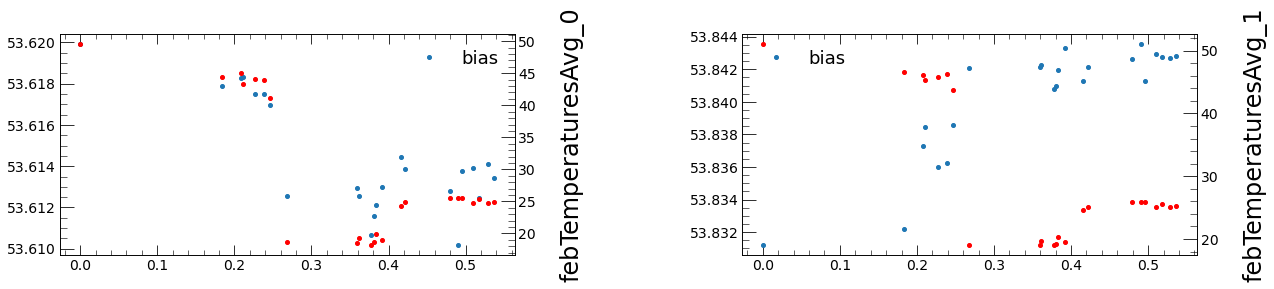

<Figure size 630x426.24 with 0 Axes>

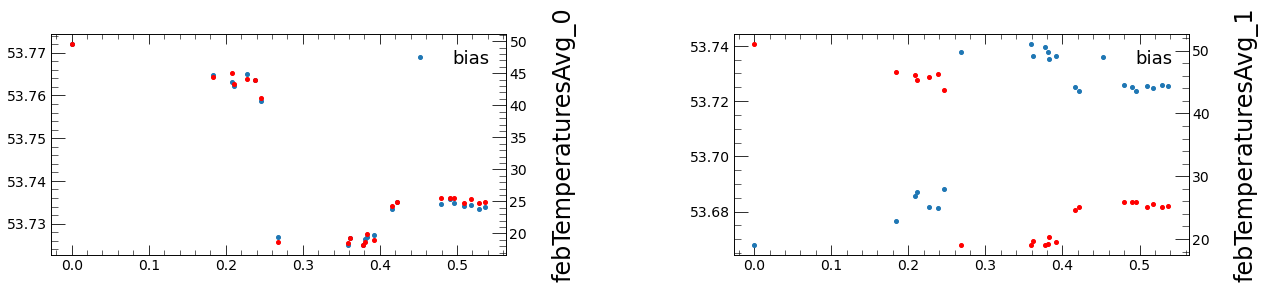

<Figure size 630x426.24 with 0 Axes>

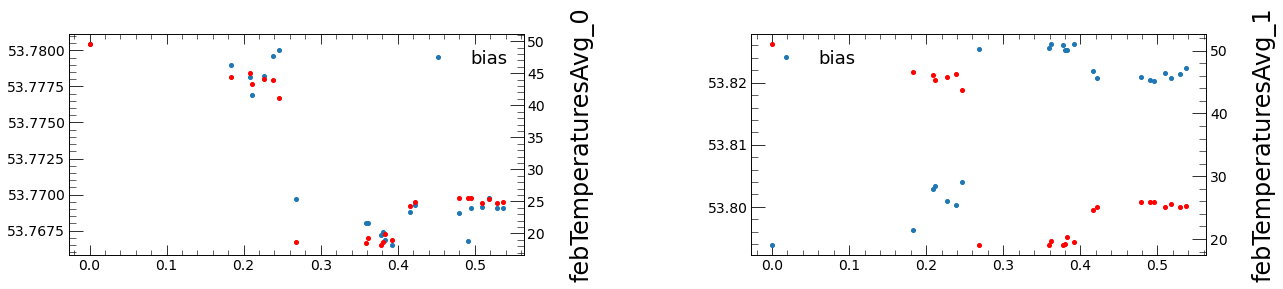

In [96]:
for i in range(0,8):

  plt.figure()
  fig, ax1 = plt.subplots(nrows=1, ncols=2, figsize=(20, 4))
  plt.subplots_adjust(wspace=0.5)

  for feb in range(0, 2):
    ax2 = ax1[feb].twinx()
    ax1[feb].plot(df['years'], df['biasVoltagesAvg_%d_%d'%(feb, i)], '.', label='bias')
    ax2.plot(df['years'], df['febTemperaturesAvg_%d'%(feb)], 'r.', label='temp')
    ax2.set_ylabel('febTemperaturesAvg_%d'%(feb))
    ax1[feb].legend()

#Make plots

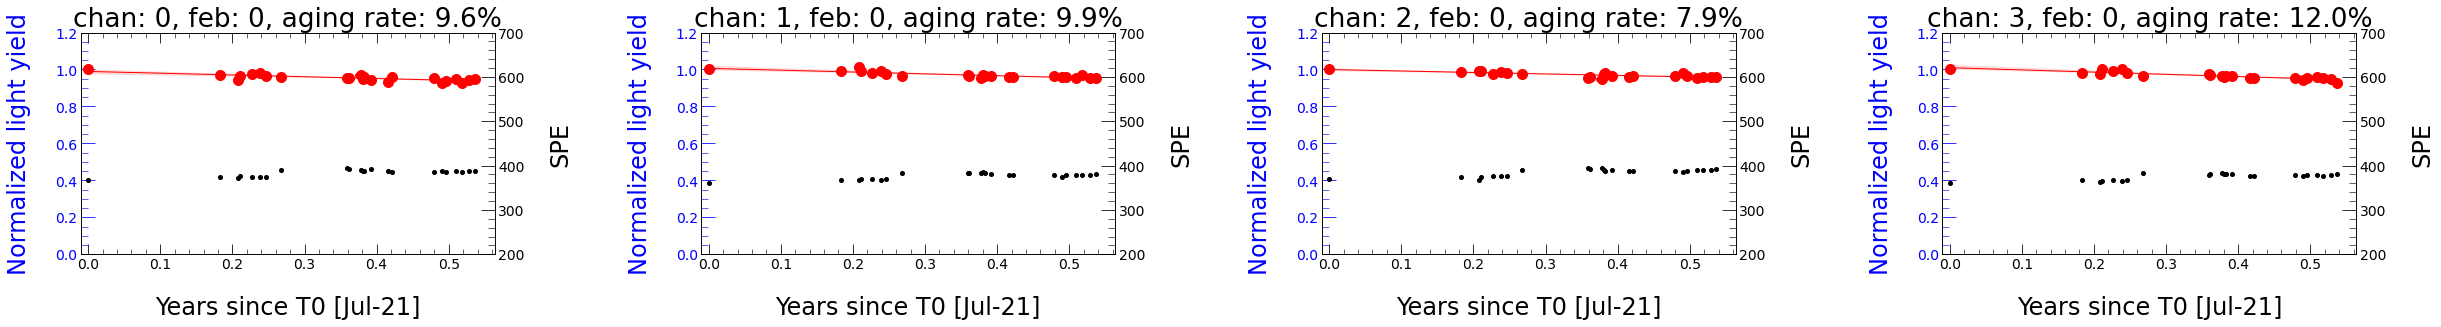

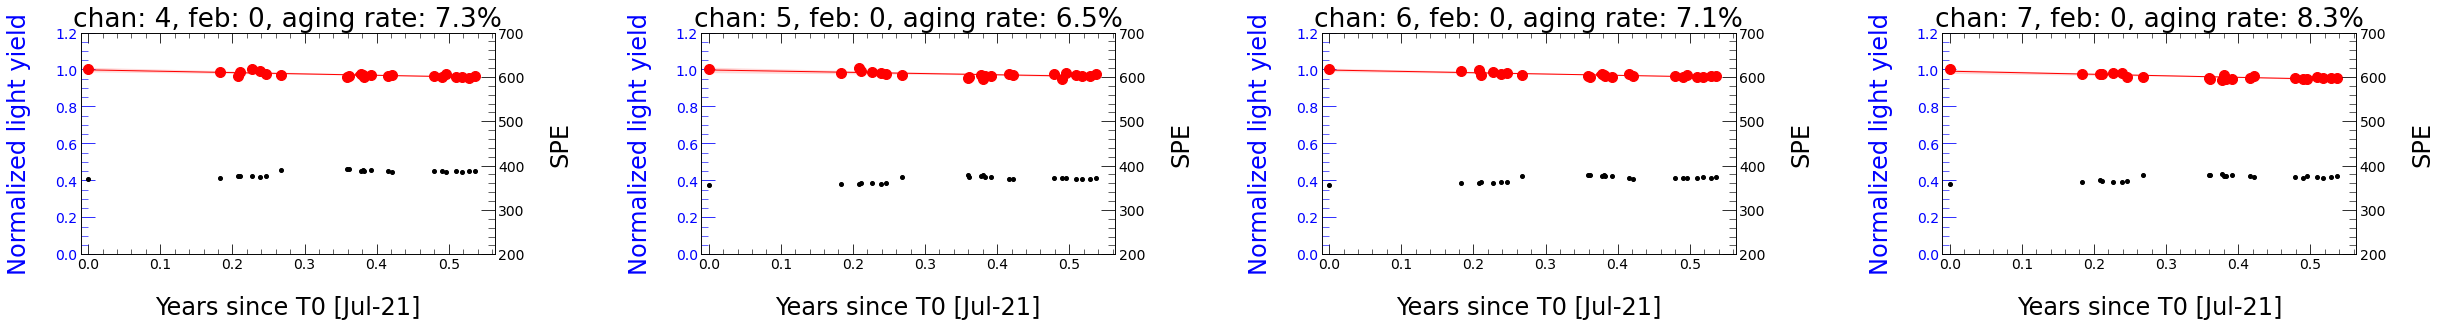

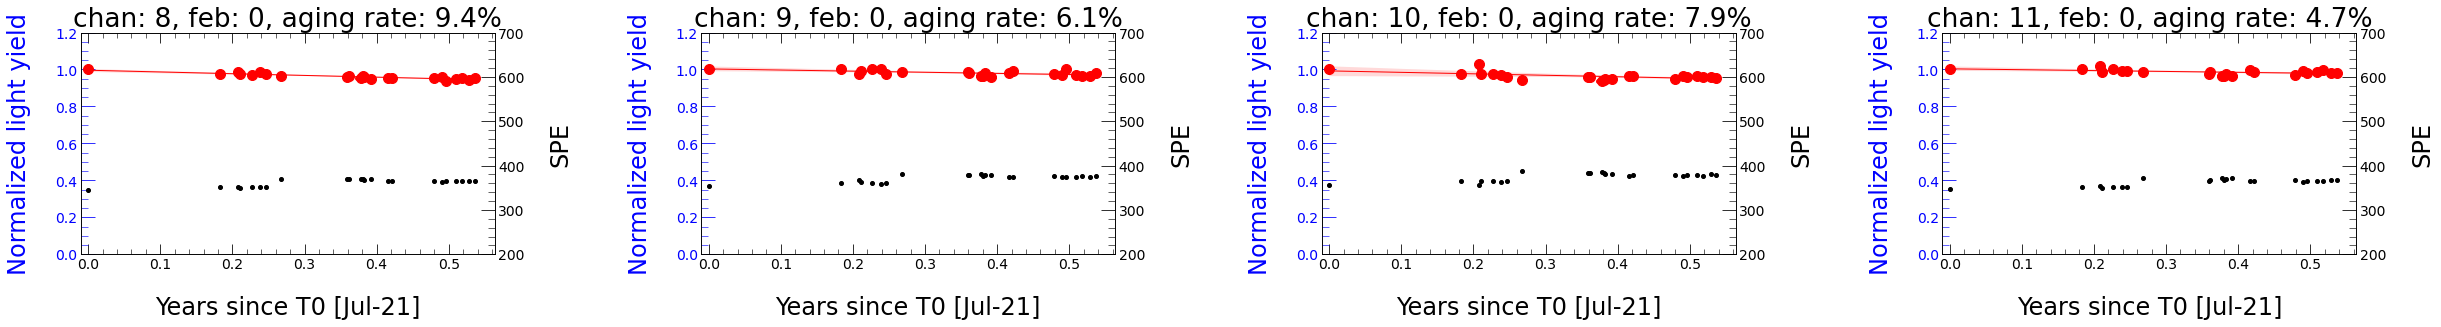

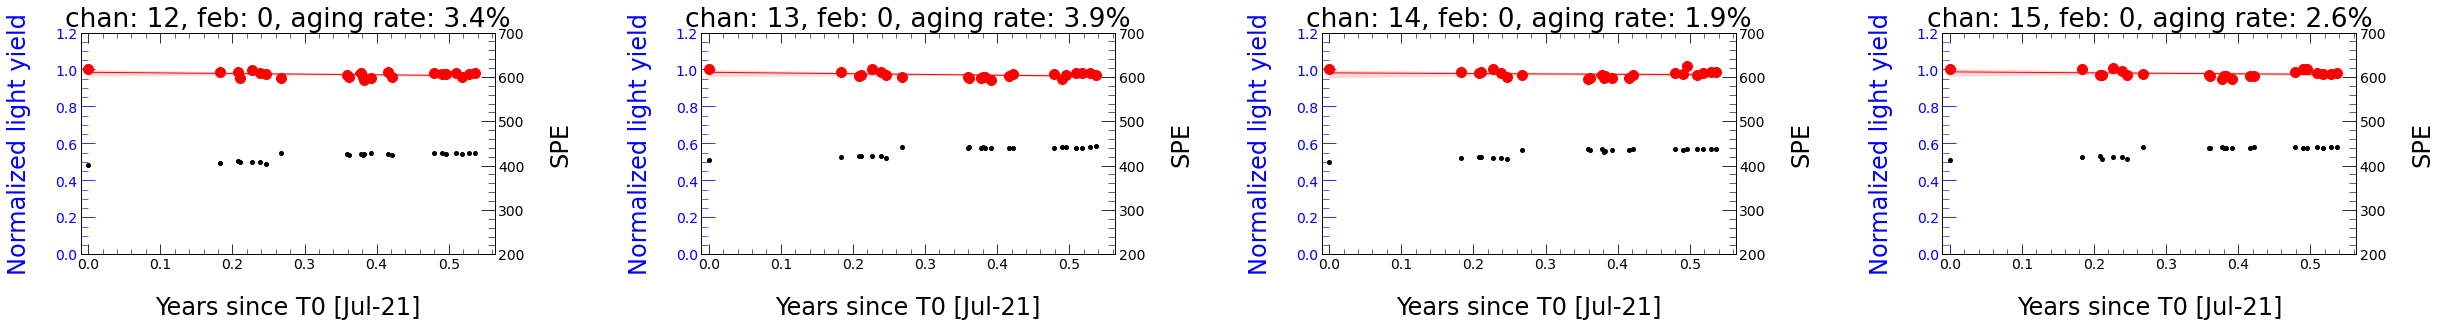

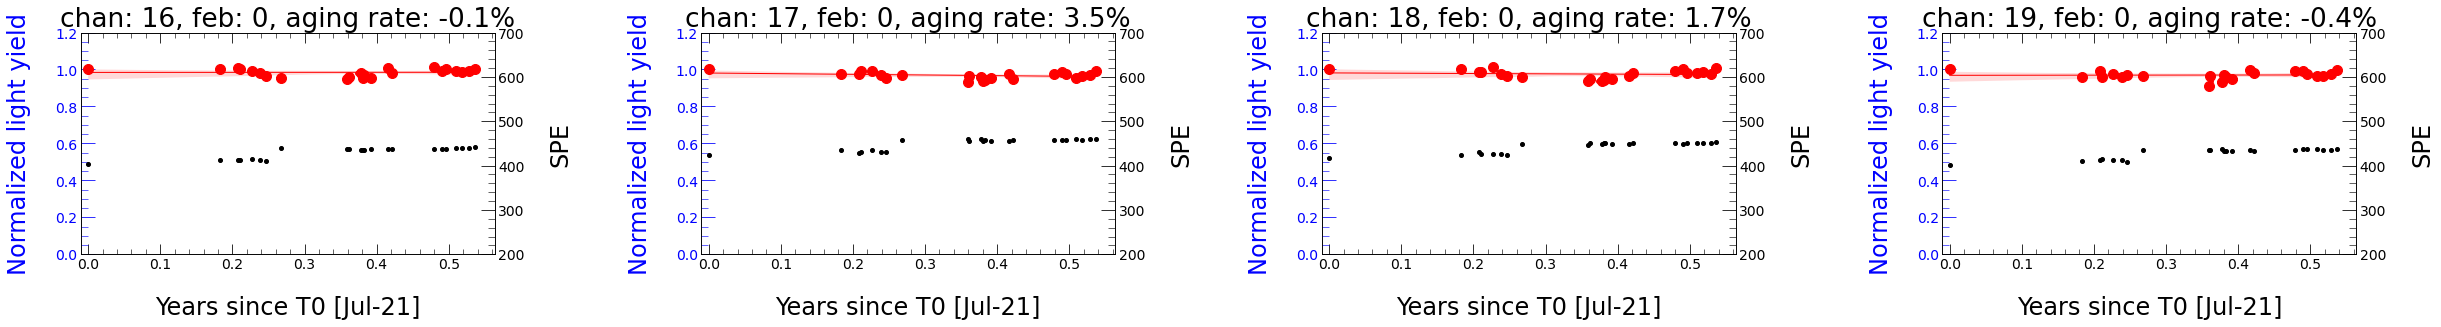

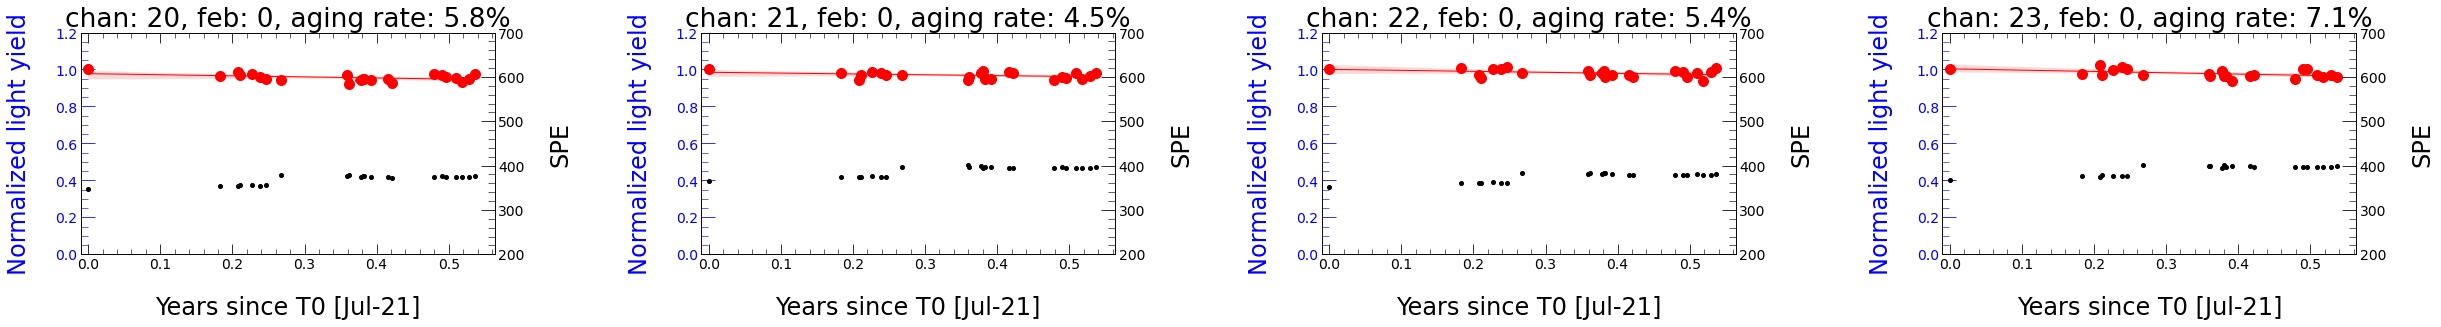

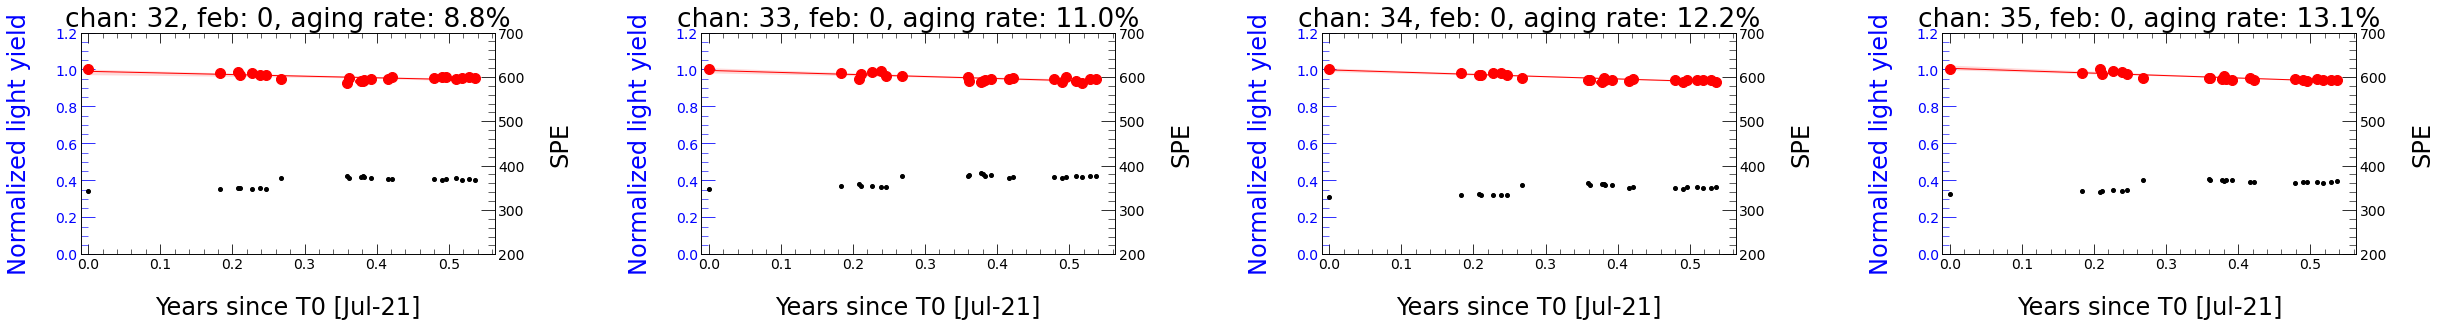

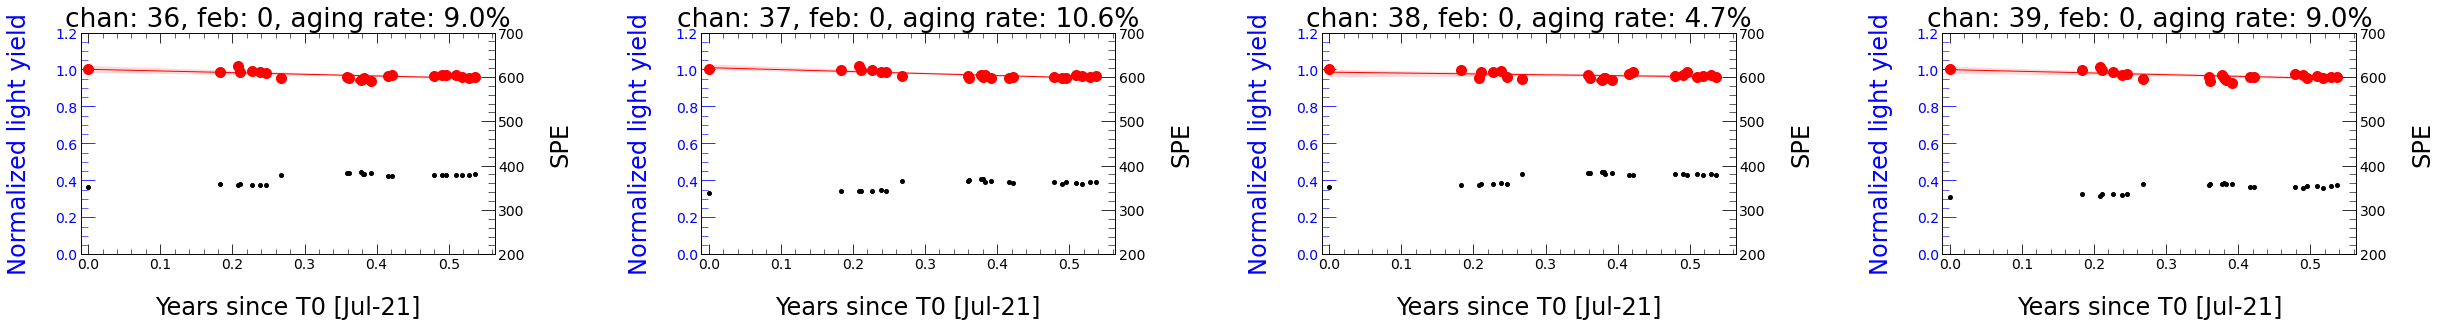

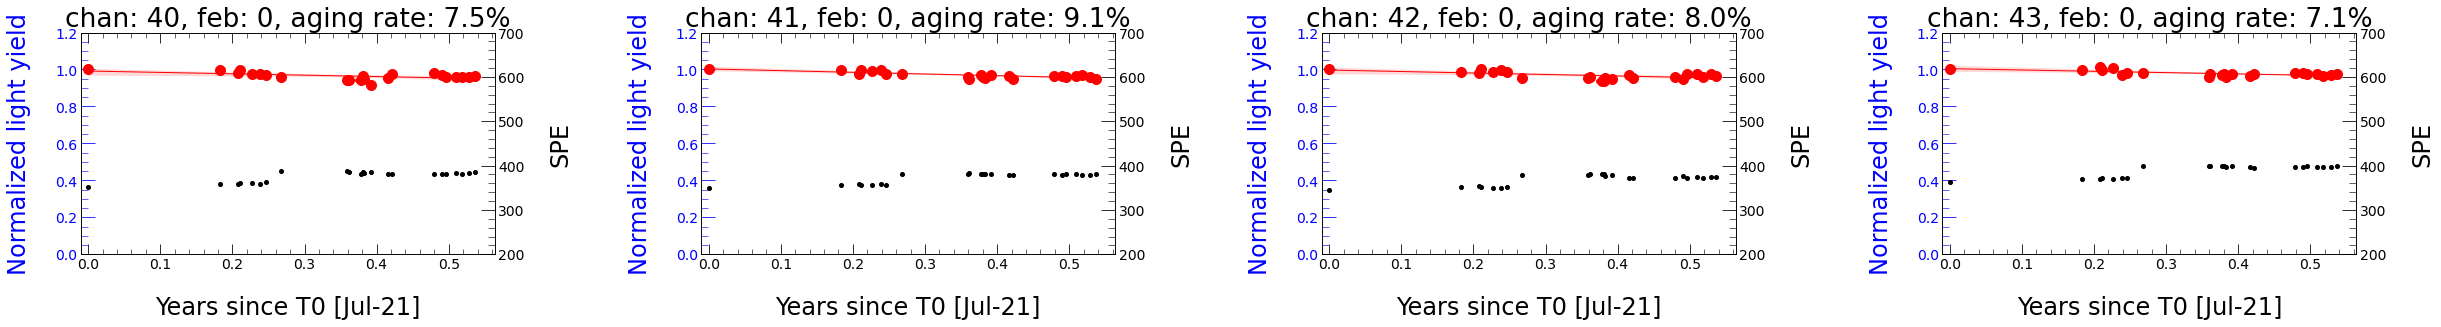

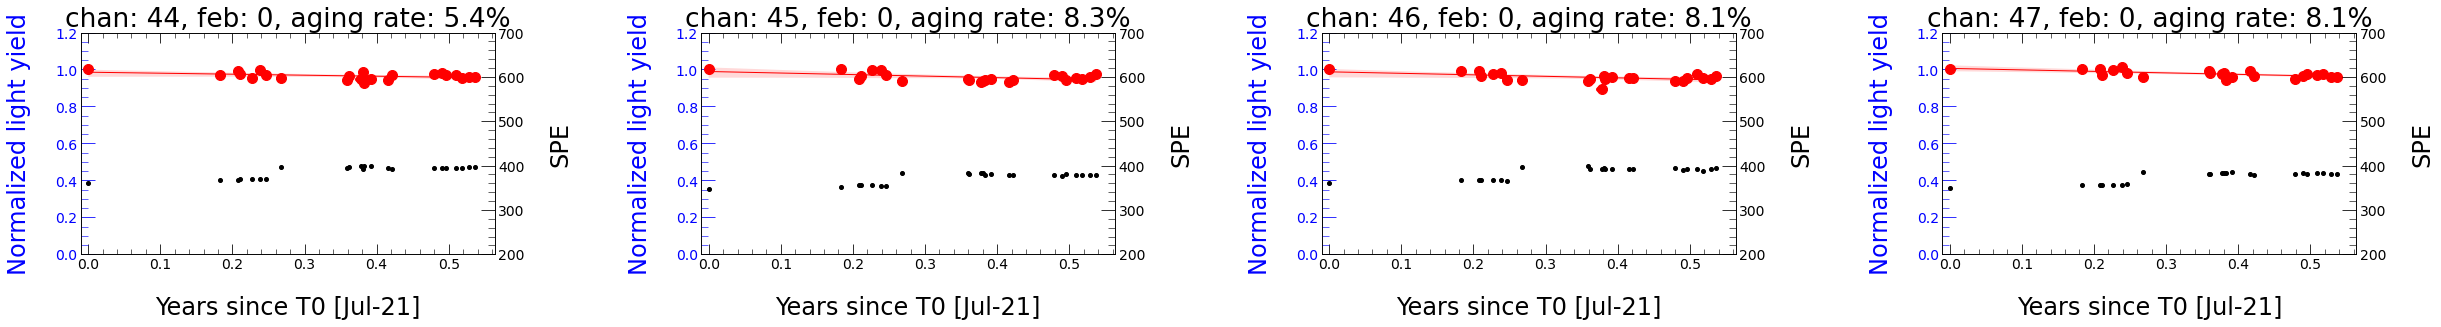

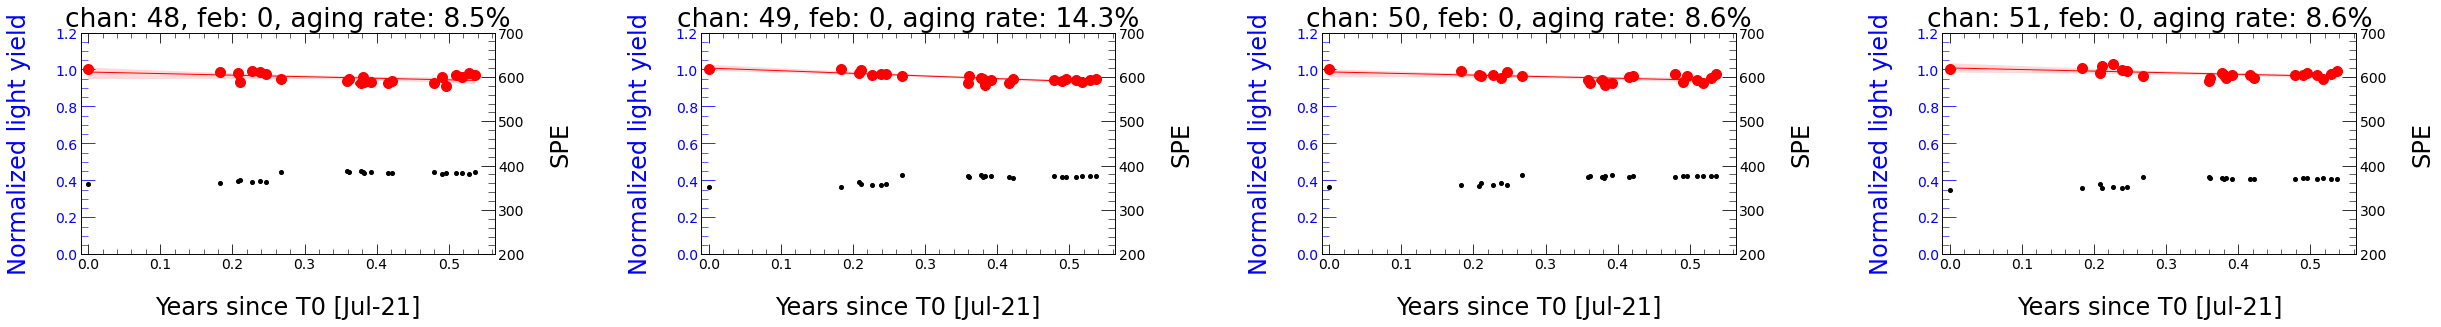

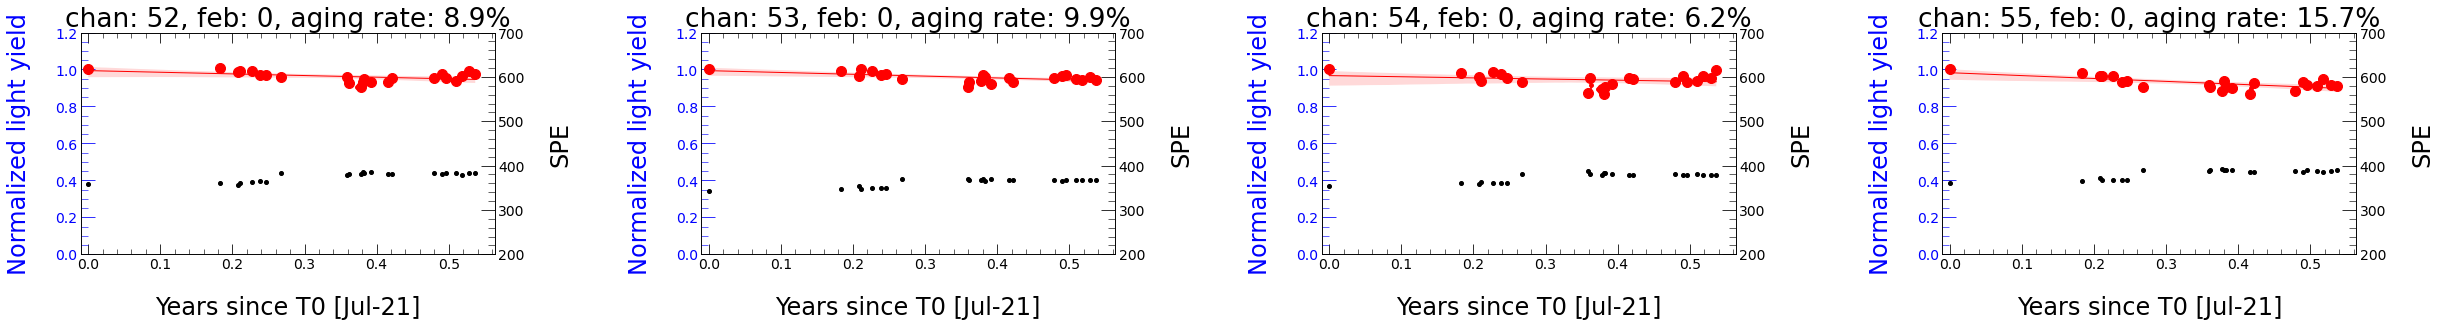

In [89]:
aging_pct=[]
hdmi_range=list(range(0, 6))+list(range(8, 14))

for feb in range(0, 1):
  for hdmi in hdmi_range:
    fig, ax1 = plt.subplots(nrows=1, ncols=4, figsize=(40, 4))
    plt.subplots_adjust(wspace=0.5)

    for chan in range(0, 4):
      ax2 = ax1[chan].twinx()
#      ax3 = ax1[chan].twinx()
#      ax3.spines.right.set_position(("axes", 1.2))

      #Plot normalized PE over years
      chan_infeb = hdmi*4+chan
      x=df['years'].to_numpy()
      y=df['PEsTemperatureCorrected_%d_%d'%(feb, chan_infeb)].to_numpy()
      y=y/y[0]

      ax1[chan].plot(x, y , 'ro', label="Normalized light yield", markersize=10.0)
      ax1[chan].set_ylim(0,1.2)
      ax1[chan].set_xlim(-0.01)
      ax1[chan].set_xlabel("Years since T0 [Jul-21]")
      ax1[chan].set_ylabel('Normalized light yield', color='b')
      ax1[chan].tick_params(axis='y', which='both', colors='b')

      #Fit the aging curve
#      x=df.query('chan==%d and feb==%d and years<0.68'%(hdmi*4+chan,feb))['years'].to_numpy()
#      y=df.query('chan==%d and feb==%d and years<0.68'%(hdmi*4+chan,feb))['PEcorr'].to_numpy()
#      y=y/y[0]
      sns.regplot(x=x, y=y, x_bins=np.linspace(-0.1,1.1,110), fit_reg=True, label='Fit', ax=ax1[chan], color='red', marker='o', scatter_kws={'s':15}, line_kws={'linewidth':1})
      slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
      ax1[chan].set_title('chan: %d, feb: %d, aging rate: %.1f%%'%(hdmi*4+chan,feb,-slope*100))

      #Plot temp corr SPE over time
#      x=df.query('chan==%d and feb==%d'%(hdmi*4+chan,feb))['years'].to_numpy()
#      y=df.query('chan==%d and feb==%d'%(hdmi*4+chan,feb))['speT'].to_numpy()
      y=df['calibConstantsTemperatureCorrected_%d_%d'%(feb, chan_infeb)].to_numpy()
      ax2.plot(x, y , 'k.')
      ax2.set_ylim(200,700)
      ax2.set_ylabel('SPE', color='k');

      #Plot temp over time
 #     ax3.plot(df_temp['years_temp'], df_temp['temp'], 'r-', markersize=0.2, linewidth=0.5, alpha=0.7)
 #     ax3.plot(df['years'], df['temp'], 'ro', markersize=2.0, linewidth=0.5, alpha=0.7)
 #     ax3.set_ylabel('Temp [C]', color='r')
 #     ax3.tick_params(axis='y', which='both', colors='r')

      #Append aging for FEB0 only.
      if(feb==0):
        aging_pct.append(-slope*100)

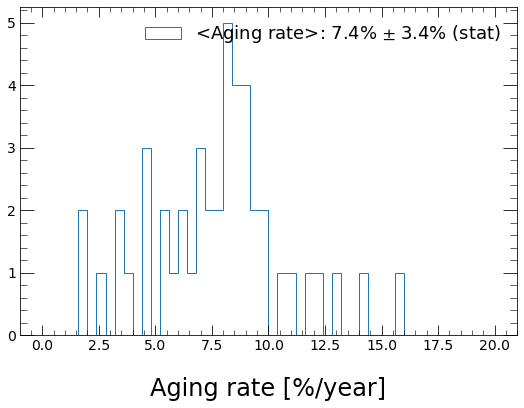

In [97]:
plt.hist(aging_pct, bins=50, range=(0,20), histtype='step', label='<Aging rate>: %.1f%% $\pm$ %.1f%% (stat)'%(np.mean(aging_pct), np.std(aging_pct)) );
plt.xlabel('Aging rate [%/year]');
plt.legend();

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


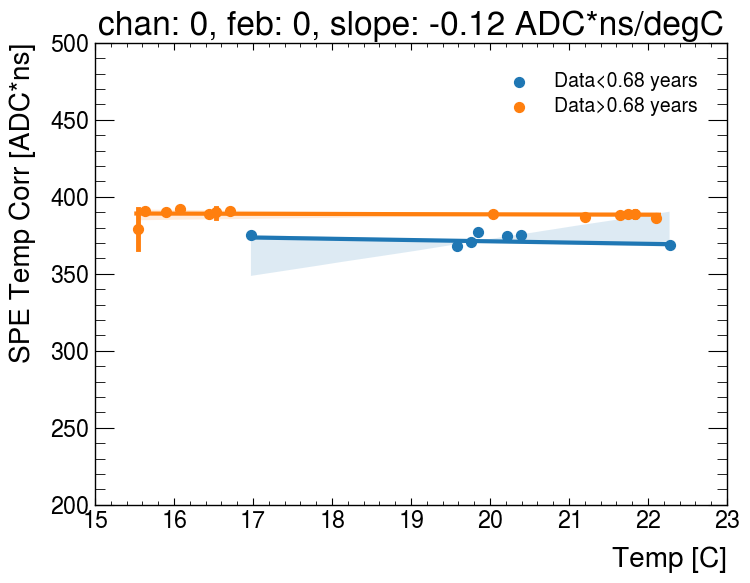

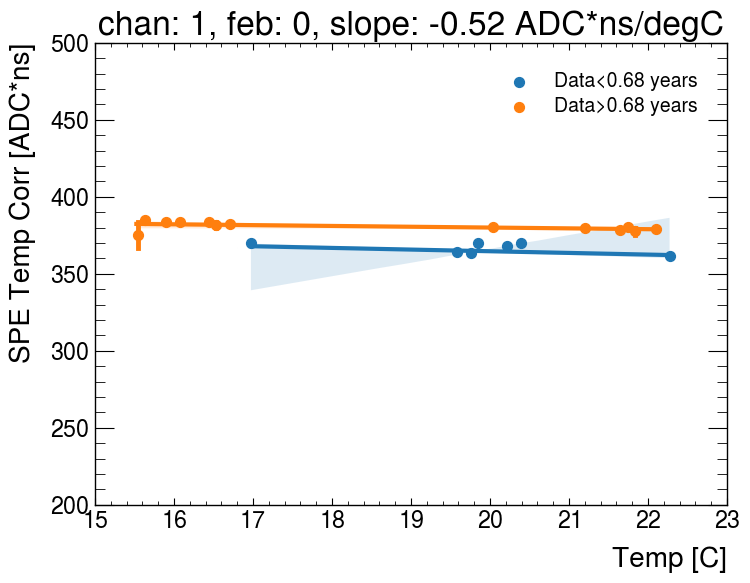

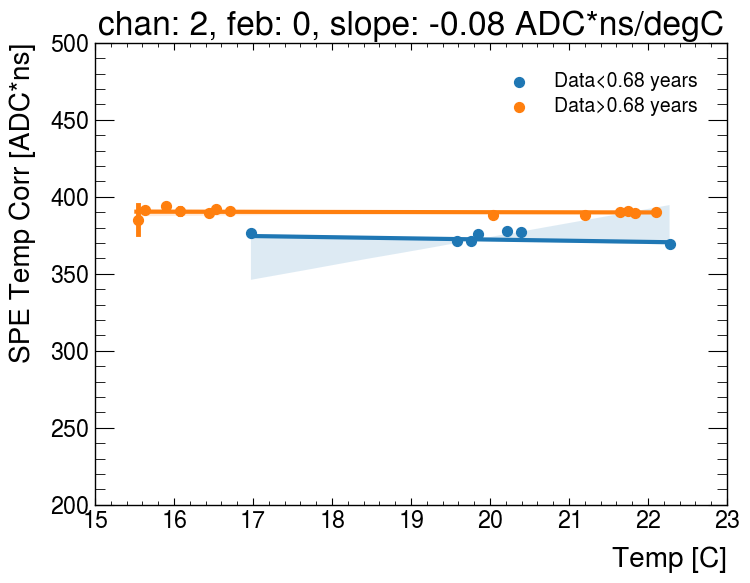

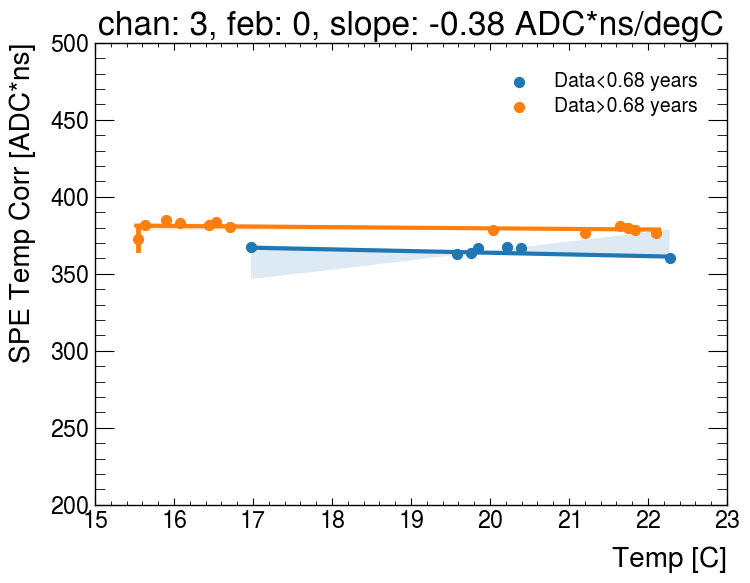

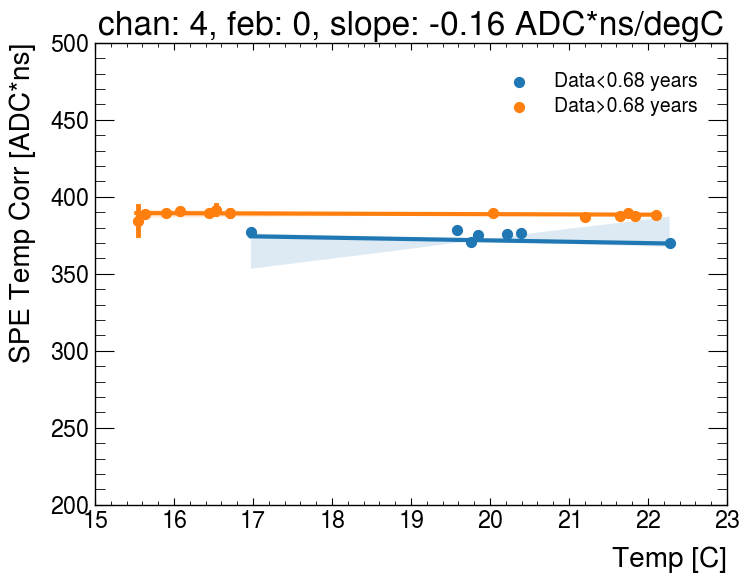

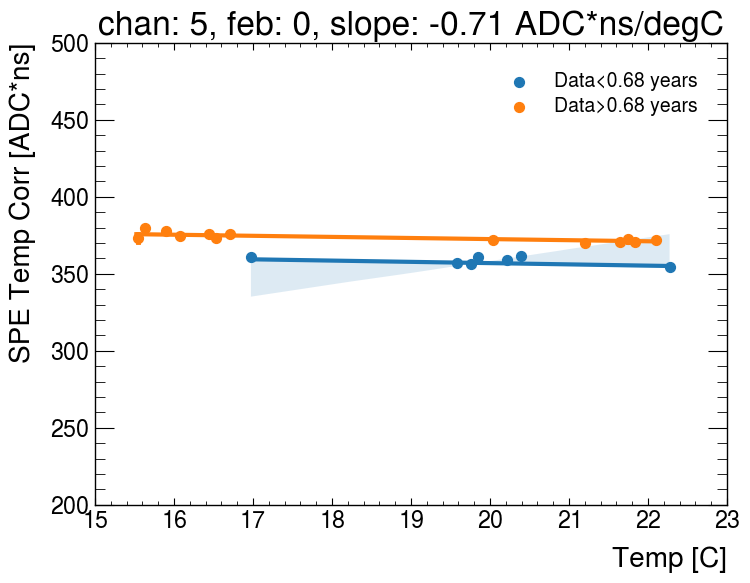

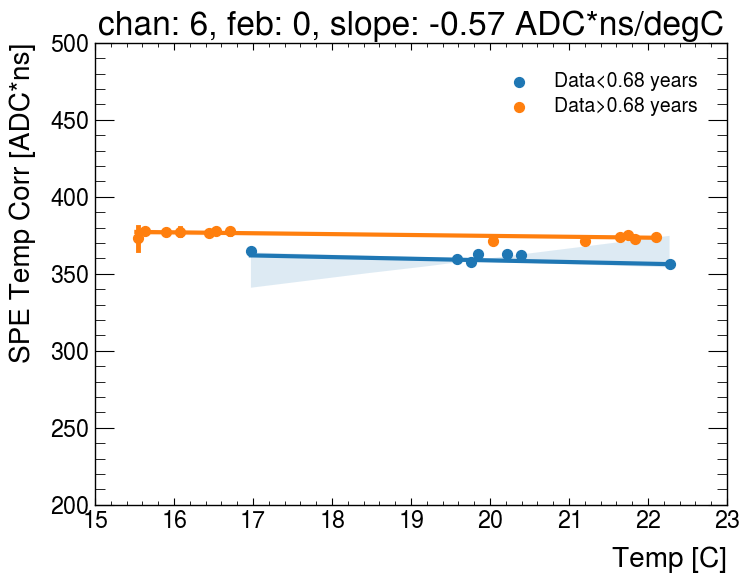

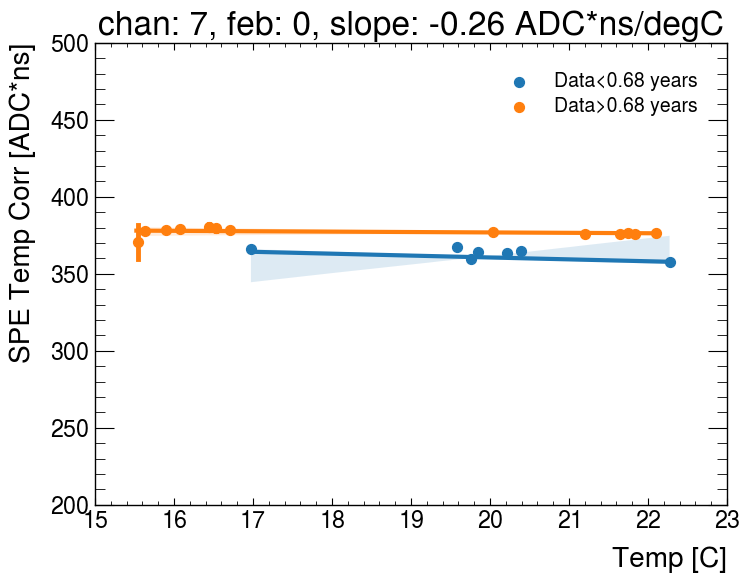

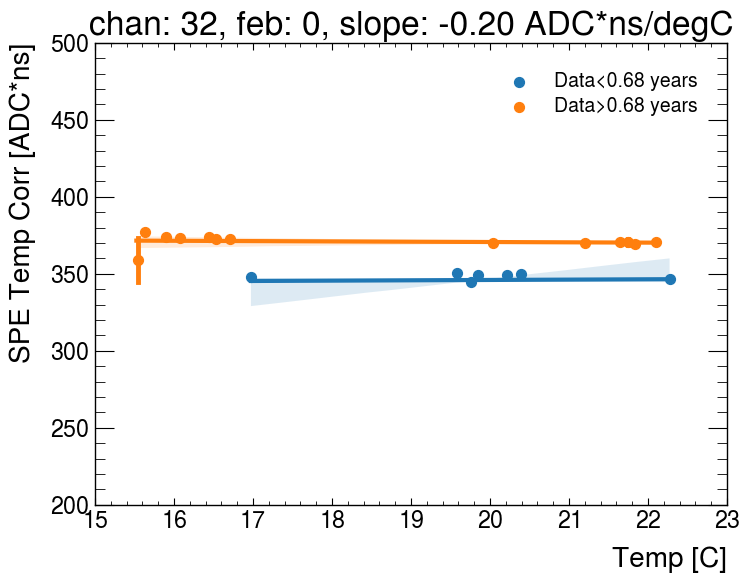

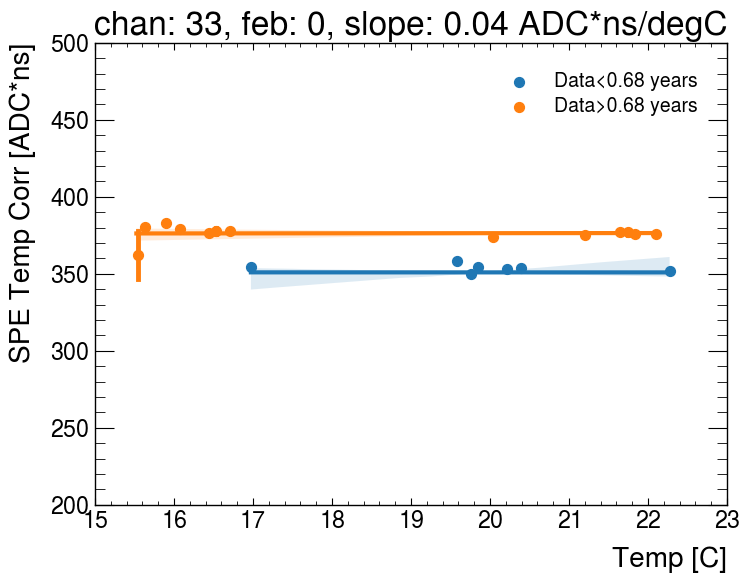

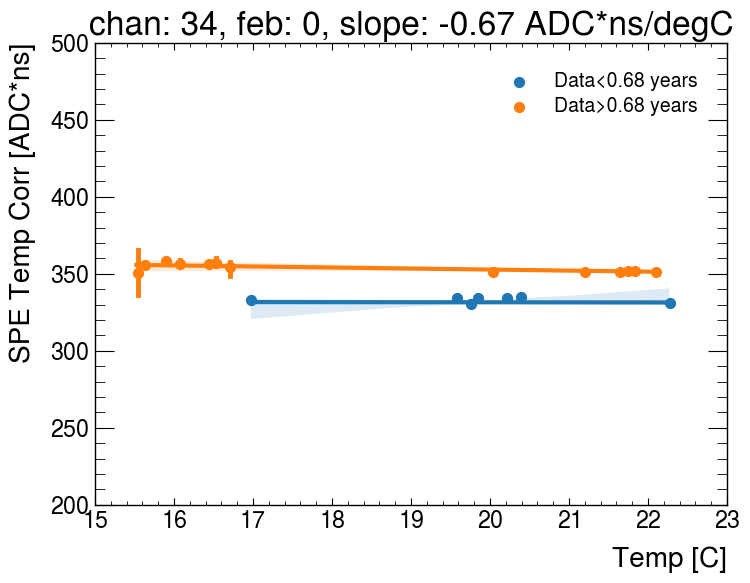

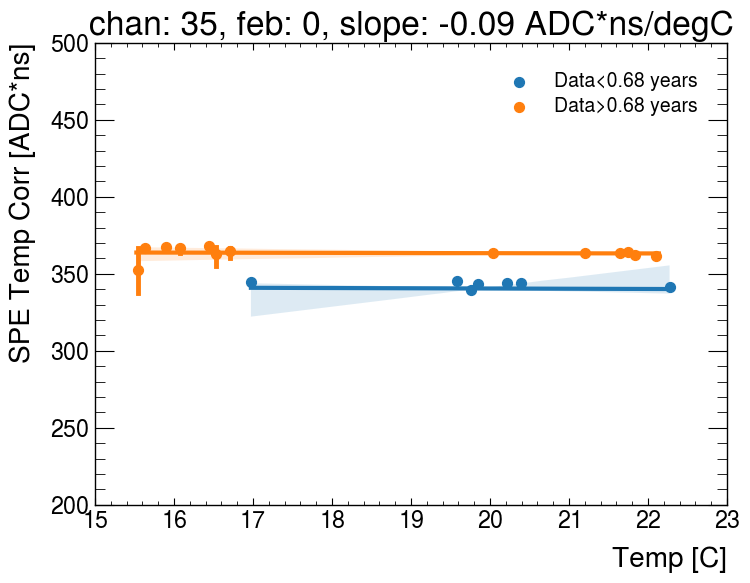

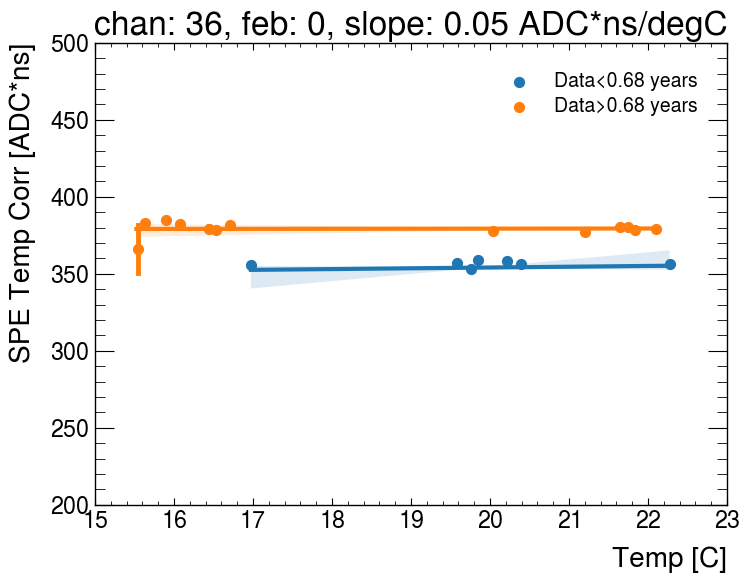

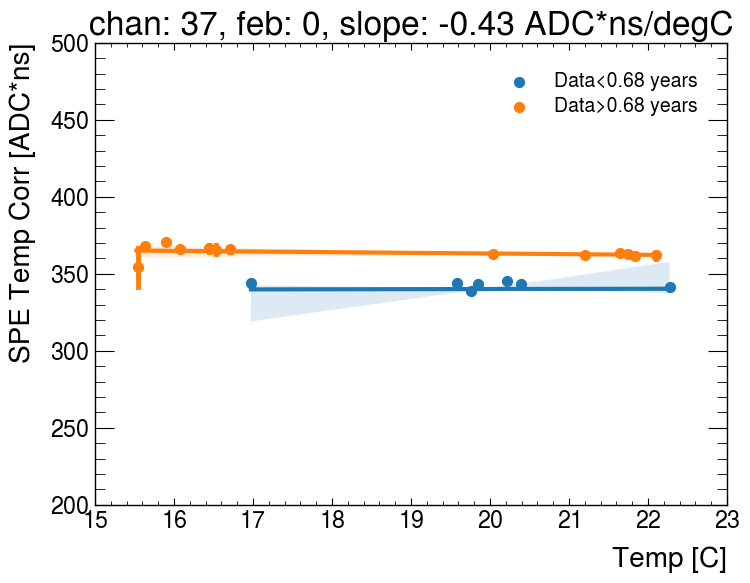

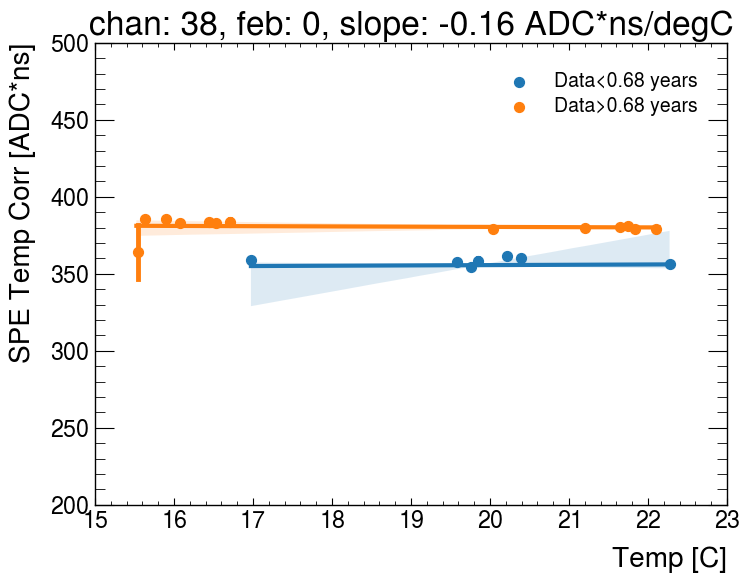

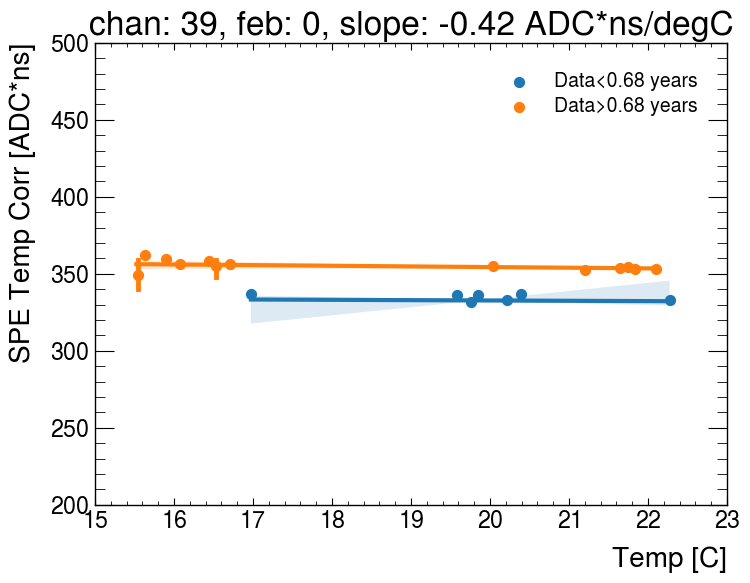

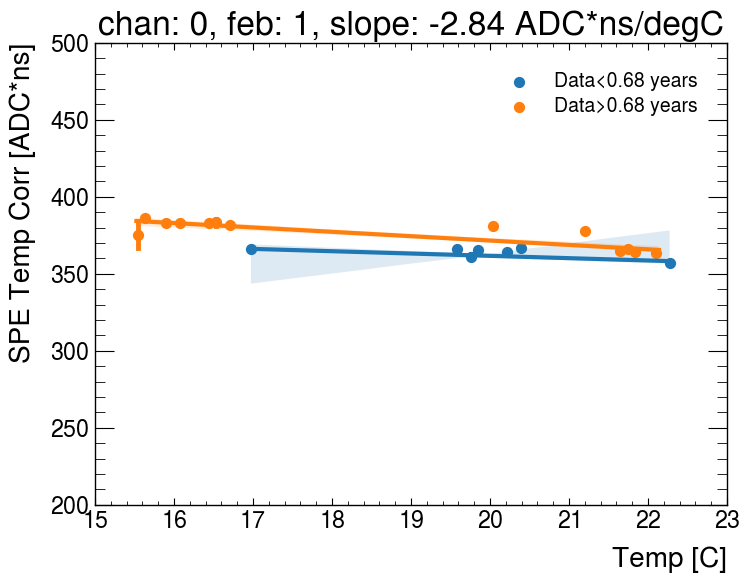

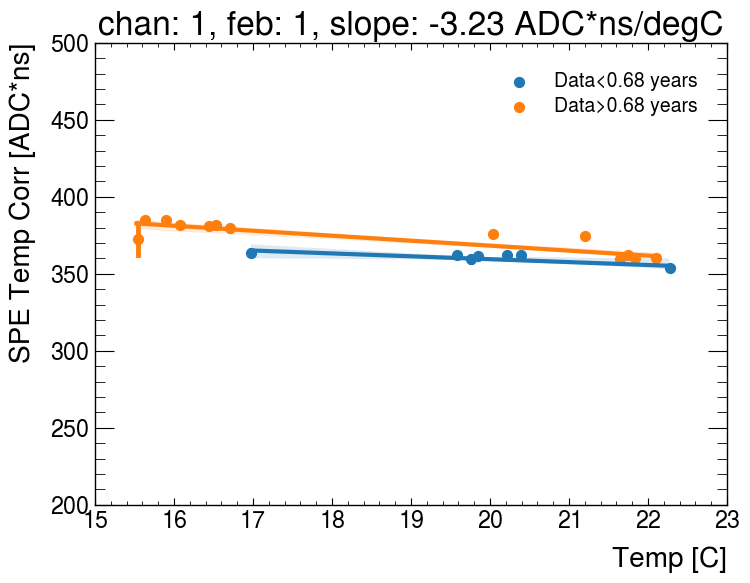

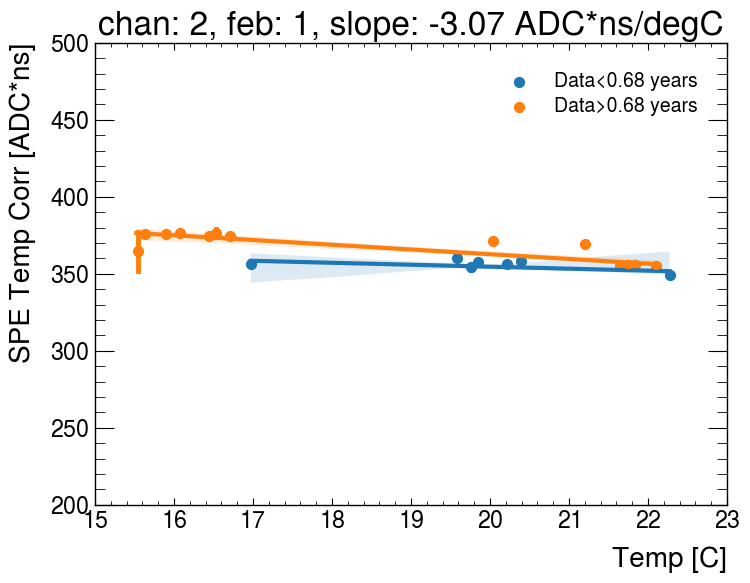

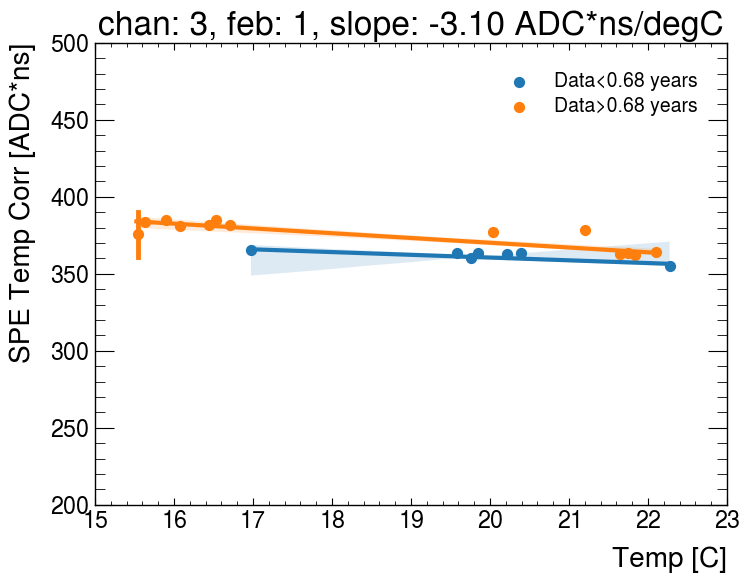

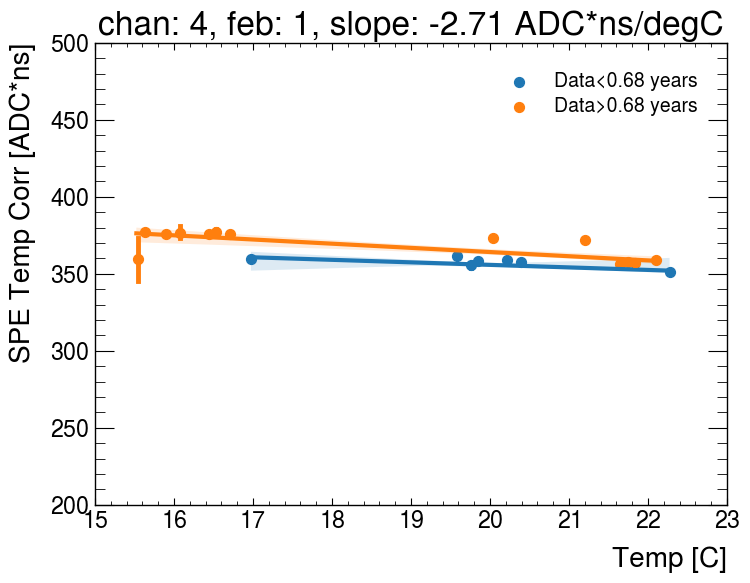

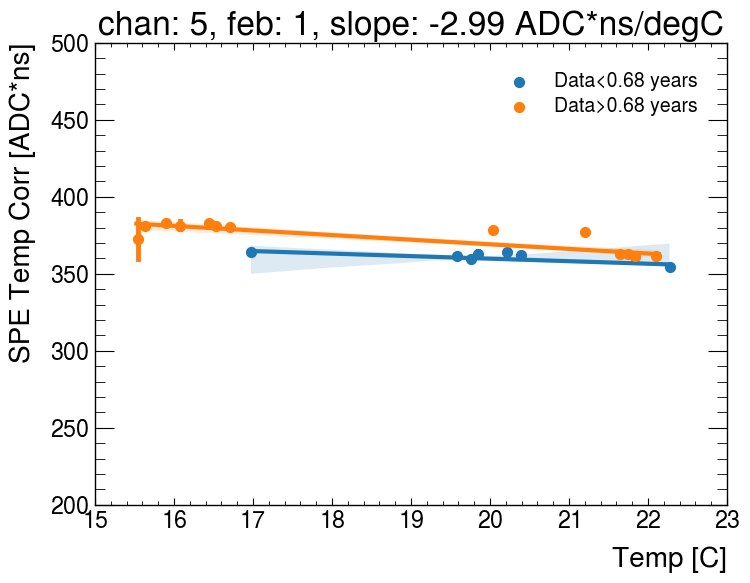

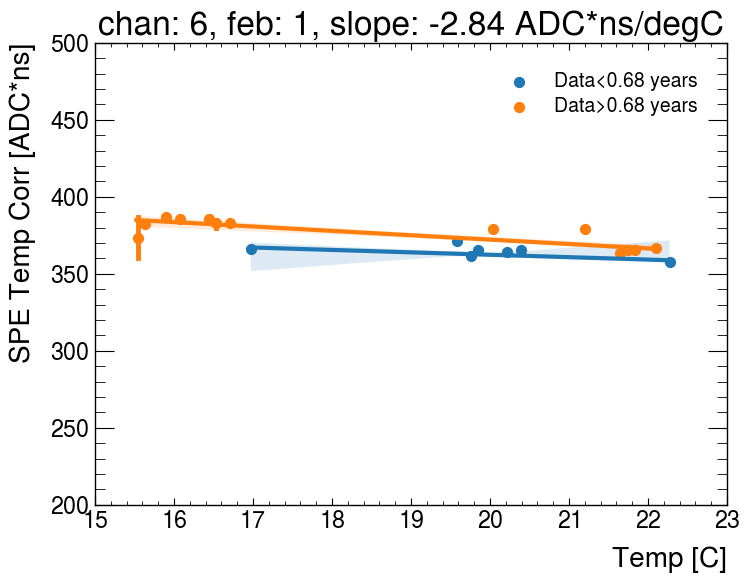

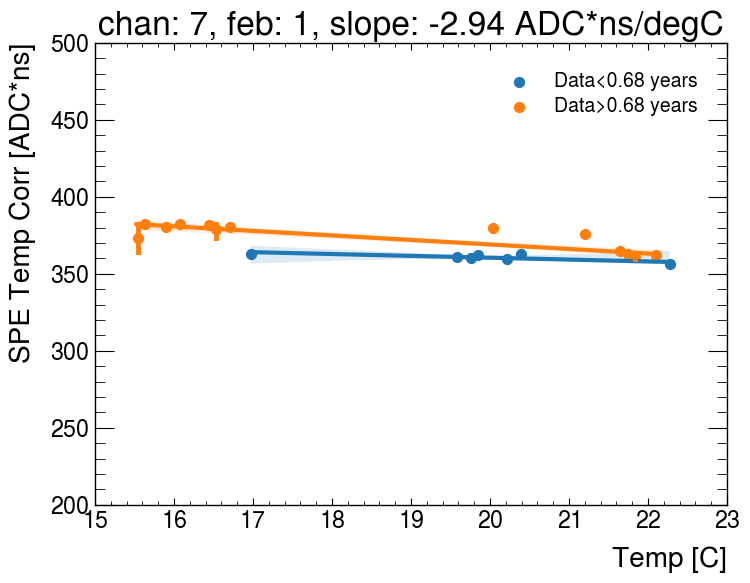

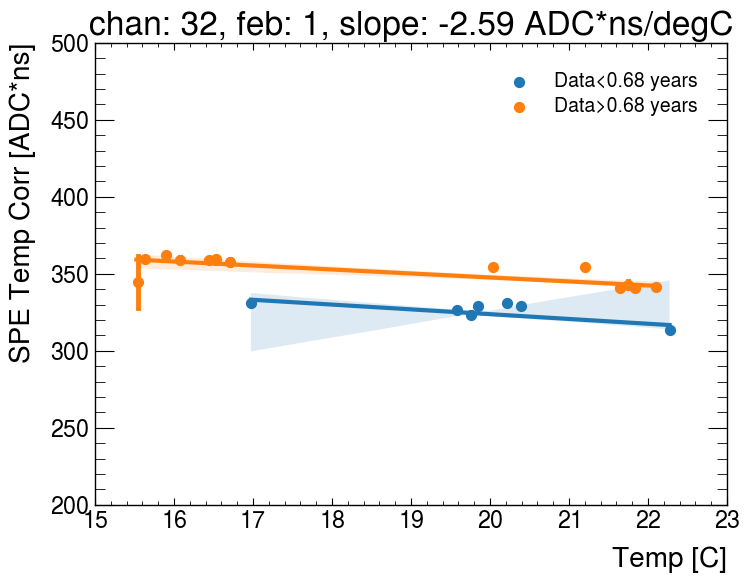

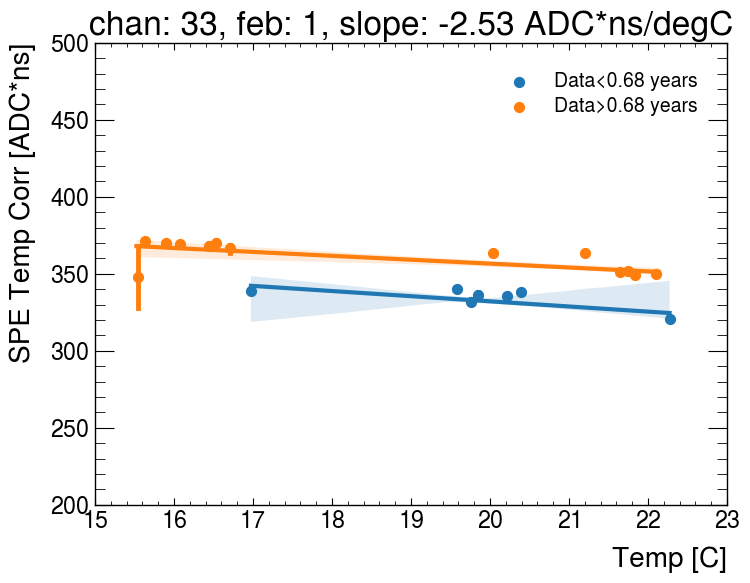

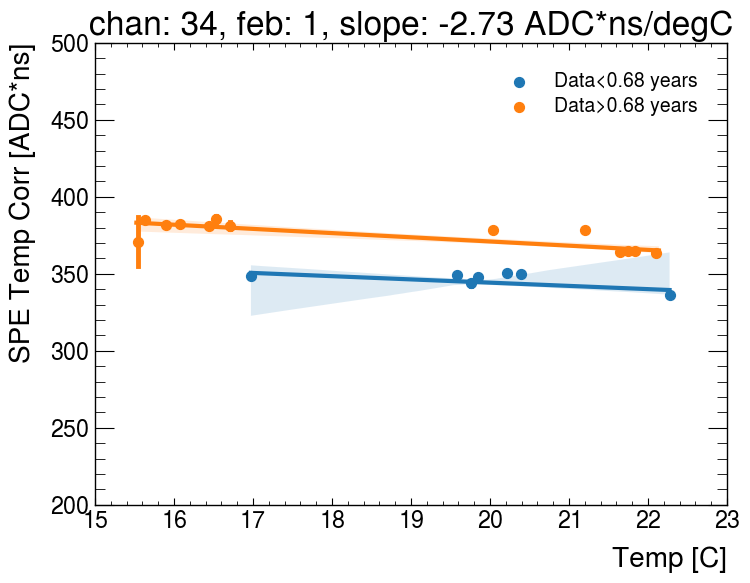

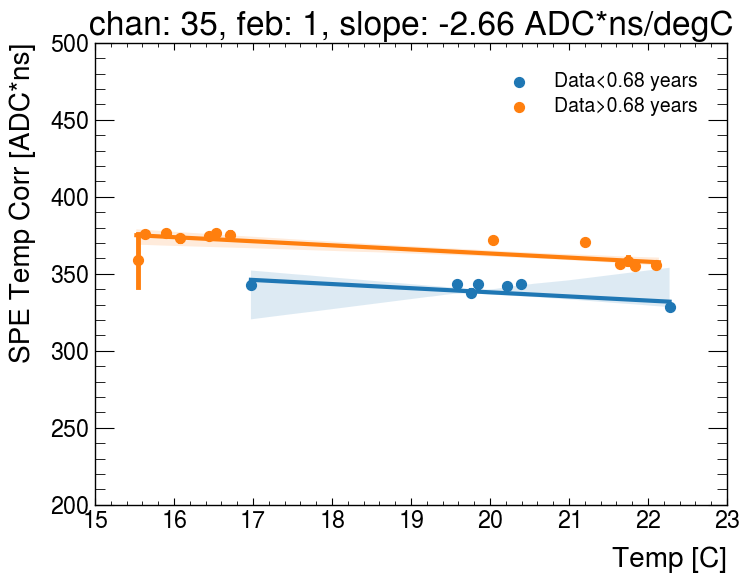

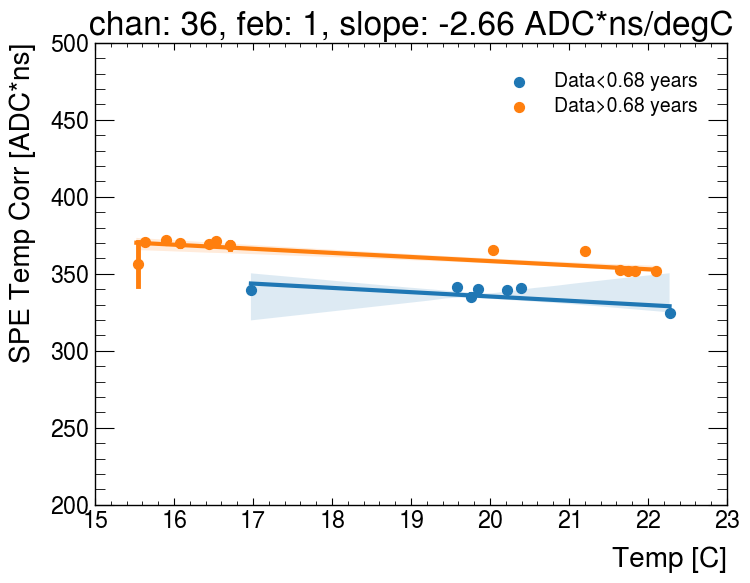

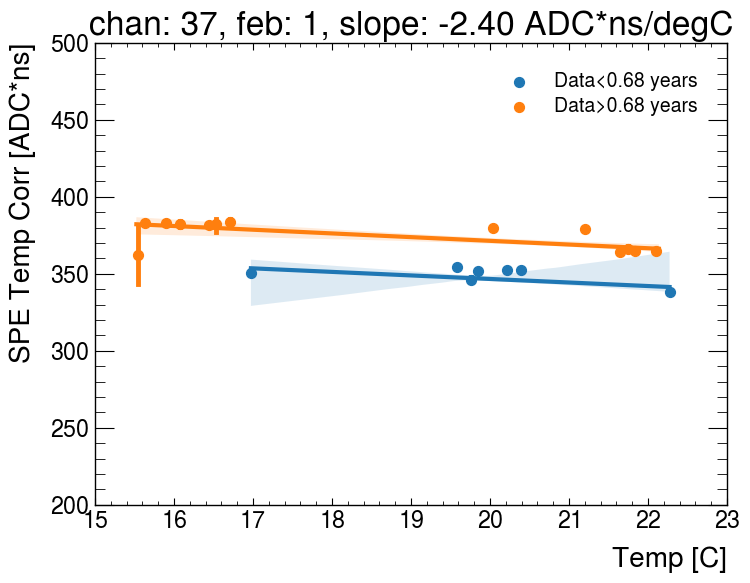

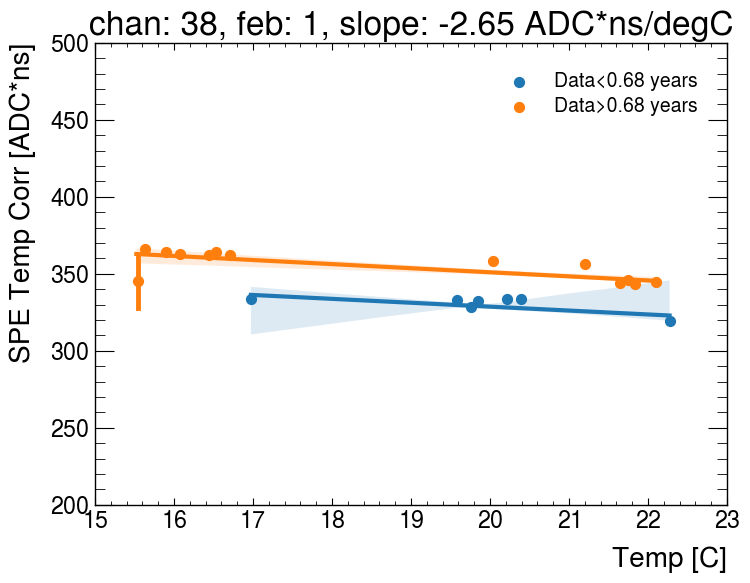

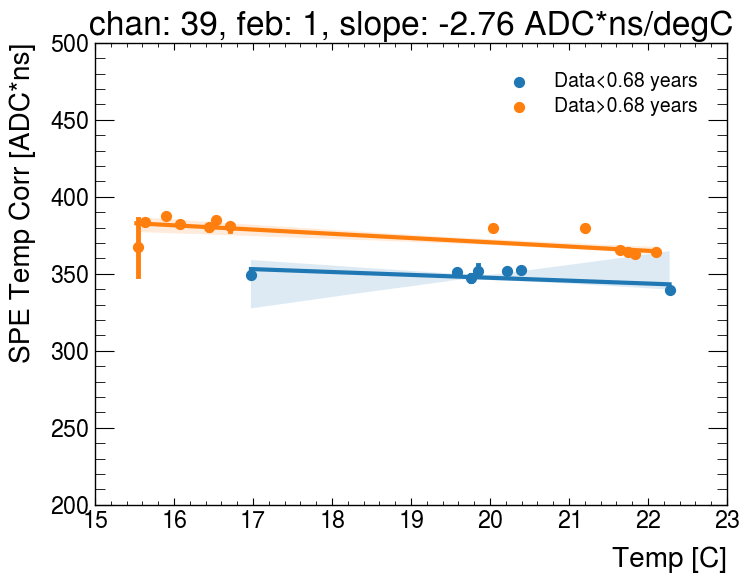

In [ ]:
channel_range=list(range(0, 8))+list(range(32, 40))
#channel_range=list(range(0, 2))

for feb in range(0, 2):
  for chan in channel_range:
    plt.figure()    
    x=df.query('chan==%d and feb==%d and years<0.68'%(chan,feb))['temp'].to_numpy()
    y=df.query('chan==%d and feb==%d and years<0.68'%(chan,feb))['speT'].to_numpy()
    sns.regplot(x=x, y=y, x_bins=np.linspace(15,23,90), fit_reg=True, label='Data<0.68 years')

    x=df.query('chan==%d and feb==%d and years>0.68'%(chan,feb))['temp'].to_numpy()
    y=df.query('chan==%d and feb==%d and years>0.68'%(chan,feb))['speT'].to_numpy()
    sns.regplot(x=x, y=y, x_bins=np.linspace(15,23,90), fit_reg=True, label='Data>0.68 years')
    slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
    plt.legend()

    plt.title('chan: %d, feb: %d, slope: %.2f ADC*ns/degC'%(chan,feb, slope))
    plt.ylabel('SPE Temp Corr [ADC*ns]')
    plt.xlabel('Temp [C]')
    plt.ylim(200, 500)

In [ ]:
def highlight(s):
    if s.speT > 380:
        return ['background-color: darkblue'] * len(s)
    else:
        return ['background-color: black'] * len(s)

df.query('chan==0 and feb==0 and subrun==0').style.apply(highlight, axis=1)

,days,idx,temp,rh,dew,years_temp,date,run,feb,chan,PE,PEcorr,subrun,ped,spe,speT,years
128,737979,5324.500000,22.273380,39.298750,46.003125,0.000000,2021-07-08,66,0,0,39.291900,38.674000,0,25.110900,379.772000,367.833000,0.000000
1658,738134,12766.500000,19.793171,31.129375,35.941667,0.424658,2021-12-10,94,0,0,40.462400,37.725400,0,24.974400,408.483000,368.584000,0.424658
2751,738167,14350.500000,19.772454,24.828125,30.352083,0.515068,2022-01-12,105,0,0,39.995500,37.075100,0,24.953700,411.565000,371.271000,0.515068
3262,738201,15982.500000,19.865625,20.554167,25.923750,0.608219,2022-02-15,119,0,0,39.315700,36.680500,0,25.264400,413.265000,376.155000,0.608219
3390,738210,16414.500000,19.600579,20.364375,25.303958,0.632877,2022-02-24,1009,0,0,39.393600,36.168200,0,24.753600,405.902000,368.038000,0.632877
3506,738211,16462.500000,19.856481,21.087292,26.523125,0.635616,2022-02-25,1010,0,0,39.109000,36.268300,0,24.704700,418.681000,378.414000,0.635616
3628,738217,16750.500000,20.403356,23.021458,29.390417,0.652055,2022-03-03,1013,0,0,39.176100,36.733000,0,24.659700,408.381000,374.896000,0.652055
3882,738221,16942.500000,20.182523,27.335208,33.367292,0.663014,2022-03-07,1020,0,0,39.794000,37.021100,0,24.701100,411.377000,374.427000,0.663014
4009,738224,17086.500000,16.973958,23.971458,25.265833,0.671233,2022-03-10,1021,0,0,41.539000,36.477700,0,24.838900,446.298000,375.179000,0.671233
4377,738232,17468.500000,16.503125,43.275833,39.165625,0.693151,2022-03-18,1022,0,0,41.256800,36.404500,0,24.887400,463.640000,390.713000,0.693151


In [ ]:
'''
channel_range=list(range(0, 10))+list(range(33, 43))
#channel_range=list(range(0, 2))

for feb in range(0, 2):
  for chan in channel_range:
    plt.figure()
    x=df.query('chan==%d and feb==%d'%(chan,feb))['temp'].to_numpy()
    y=df.query('chan==%d and feb==%d'%(chan,feb))['spe'].to_numpy()
    sns.regplot(x=x, y=y, x_bins=np.linspace(15,23,90), fit_reg=None, label='Exluded points')
    x=df.query('chan==%d and feb==%d and (temp<16.8 or temp>20.5) and temp<22.2'%(chan,feb))['temp'].to_numpy()
    y=df.query('chan==%d and feb==%d and (temp<16.8 or temp>20.5) and temp<22.2'%(chan,feb))['spe'].to_numpy()
    sns.regplot(x=x, y=y, x_bins=np.linspace(15,23,90), fit_reg=None, label='Fit points')
    plt.legend()

    #Fit the aging curve
    z4, res, _, _, _ = np.polyfit(x, y, 1, full=True)
    p4 = np.poly1d(z4)
    xx = np.linspace(x.min(), x.max(), 100)
    plt.plot(xx, p4(xx), '-g')
    plt.title('chan: %d, feb: %d, slope: %.1f ADC*ns/degC'%(chan,feb,p4[1]))
    plt.ylabel('SPE Temp Uncorr [ADC*ns]')
    plt.xlabel('Temp [C]')
    plt.ylim(200, 600)
  '''

"\nchannel_range=list(range(0, 10))+list(range(33, 43))\n#channel_range=list(range(0, 2))\n\nfor feb in range(0, 2):\n  for chan in channel_range:\n    plt.figure()\n    x=df.query('chan==%d and feb==%d'%(chan,feb))['temp'].to_numpy()\n    y=df.query('chan==%d and feb==%d'%(chan,feb))['spe'].to_numpy()\n    sns.regplot(x=x, y=y, x_bins=np.linspace(15,23,90), fit_reg=None, label='Exluded points')\n    x=df.query('chan==%d and feb==%d and (temp<16.8 or temp>20.5) and temp<22.2'%(chan,feb))['temp'].to_numpy()\n    y=df.query('chan==%d and feb==%d and (temp<16.8 or temp>20.5) and temp<22.2'%(chan,feb))['spe'].to_numpy()\n    sns.regplot(x=x, y=y, x_bins=np.linspace(15,23,90), fit_reg=None, label='Fit points')\n    plt.legend()\n\n    #Fit the aging curve\n    z4, res, _, _, _ = np.polyfit(x, y, 1, full=True)\n    p4 = np.poly1d(z4)\n    xx = np.linspace(x.min(), x.max(), 100)\n    plt.plot(xx, p4(xx), '-g')\n    plt.title('chan: %d, feb: %d, slope: %.1f ADC*ns/degC'%(chan,feb,p4[1]))\n    